In [1]:
!pip install torchsde

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

In [3]:
import numpy as np
import torch
import torch.optim.swa_utils as swa_utils
import torchsde
import tqdm

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (5, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
class LipSwish(torch.nn.Module):
    def forward(self, x):
        return 0.909 * torch.nn.functional.silu(x)

class MLP(torch.nn.Module):
    def __init__(self, in_size, out_size, mlp_size, num_layers, tanh):
        super().__init__()

        model = [torch.nn.Linear(in_size, mlp_size), LipSwish()]
        
        for _ in range(num_layers - 1):
            model.append(torch.nn.Linear(mlp_size, mlp_size))
            model.append(LipSwish())
        
        model.append(torch.nn.Linear(mlp_size, out_size))
       
        if tanh:
            model.append(torch.nn.Tanh())
       
        self._model = torch.nn.Sequential(*model)

    def forward(self, x):
        return self._model(x)

Consider

$$dX_t = (A_tX_t + B_tα_t)dt + \sigma_t dW_t, \quad X_0=x_0$$

Parameterize the control $\alpha$ as the output of a Neural CDE driven by $X$

$$\alpha_t = h_\theta(t,z_t) \quad dz_t = f_\theta(t,z_t)dX_t, \quad z_0 = g_\theta(x_0)$$

where $h_\theta, f_\theta, g_\theta$ are feedforward neural networks.

We rewrite the two equations 

$$dX_t = (A_tX_t + B_t h_\theta(t,z_t))dt + \sigma_t dW_t, \quad X_0 = x_0$$

$$dz_t = f_\theta(t,z_t)(A_tX_t + B_t h_\theta(t,z_t))dt + f_\theta(t,z_t) \sigma_t dW_t, \quad z_0 = g_\theta(x_0)$$

This gives a single SDE with augmented state variable $Y_t = (X_t, z_t)$. 

We then solve the optimisation 

$$\min_\theta \mathbb{E}\left[ \int_0^T((X_t)^TQ_tX_t + α_t^TR_tα_t)dt + (X_T)^TQ_TX_T) \right]$$

Here, I calculate the integral $\int_0^T((X_t)^TQ_tX_t + α_t^TR_tα_t)dt$ as :
$$ ∑^i \left[ [(X_i)^TQ_iX_i + α_i^TR_iα_i]*Δt \right]; \quad i = 0,Δt,2Δt,...,T $$ 

and the $α_i$ is calculated by $\alpha_t = h_\theta(t,z_t)$.

And I write the code for one-dimensional LQ problem, with parameters:

$$A_t = 0; \quad σ_t = σ; \quad B_t=R_t=1;\quad Q_t = 0,for\quad t\in [0,T); \quad $$
and where $ x_0,σ,Q_T>=0$ is given.


In [5]:
class SDEFunc(torch.nn.Module):
    sde_type = 'ito'
    noise_type = 'general'

    def __init__(self, hidden_size, mlp_size, num_layers, A_t, sigma_t, B_t):
        super().__init__()

        self.A_t, self.sigma_t, self.B_t = A_t, sigma_t, B_t

        self.hidden_size = hidden_size

        self.f_theta = MLP(1 + hidden_size, hidden_size * 1, mlp_size, num_layers, tanh=True)

        self.h_theta = MLP(1 + hidden_size, 1, mlp_size, num_layers, tanh=True)

    def f_and_g(self, t, y):
        # t has shape ()
        # y has shape (batch_size, 1 + hidden_size) --- this is the augmented(input) variable (log_s, z)

        t = t.expand(y.size(0), 1)

        x = y[:,0].unsqueeze(1) # log(S)
        
        z = y[:,1:] 
        
        tz = torch.cat([t, z], dim=1)
        
        h_tz = self.h_theta(tz)
#         h_tz_z = h_tx*z

        f_tz = self.f_theta(tz)
        # f_tz = 1e-8*self.f_theta(tz)
        stand = torch.tensor([1])
        stand_= stand.repeat(batch_size, 1)

        drift_x = (self.A_t*x + self.B_t*h_tz)
        drift_z = f_tz*drift_x
        drift = torch.cat([drift_x, drift_z], dim=1)

        diffusion_x = self.sigma_t*stand_
        diffusion_z = f_tz*diffusion_x
        diffusion = torch.cat([diffusion_x, diffusion_z], dim=1).view(x.shape[0], 1 + self.hidden_size, 1)
        
        return drift, diffusion

In [6]:
class SDE(torch.nn.Module):
    def __init__(self, hidden_size, mlp_size, num_layers, A_t, sigma_t, B_t, dt):
        super().__init__()
        self.g_theta = MLP(1, hidden_size, mlp_size, num_layers, tanh=True)
        self._func = SDEFunc(hidden_size, mlp_size, num_layers, A_t, sigma_t, B_t)
        self.dt = dt

    def forward(self, x0, ts):
        # ts has shape (t_size,) and corresponds to the points we want to evaluate the SDE at.
        y0 = torch.cat([x0, self.g_theta(x0)], dim=1)
        # y0 = torch.cat([x0, self.g_theta(x0)], dim=1)
    

        ys = torchsde.sdeint(self._func, y0, ts, method='euler', dt=self.dt, adaptive=False) 
    
        # normalize the data
        # y0_flat = ys[0].view(-1)
        # ys = (ys - y0_flat.mean()) / y0_flat.std()

        return ys.permute(1,0,2)

In [7]:
def results_plot(model, x0_batch, losses, controls, T, batch_size, len, v_list, a_list, times):

    ts_ = torch.linspace(0, T, len, device=device)
    t = ts_.repeat(batch_size, 1).unsqueeze(2)

    with torch.no_grad():

        generated_samples = model(x0_batch, ts_)

        t = ts_.expand(batch_size, len).unsqueeze(2)
        x = generated_samples[...,0].unsqueeze(2)
        z = generated_samples[...,1:]  
        tz = torch.cat([t, z], dim=2)

        alpha = model._func.h_theta(tz).cpu().numpy() 
      
        fig, ax = plt.subplots(1,4,figsize=(24,4))
        for k in range(batch_size):
            ax[0].plot(x[k,:,0], alpha=0.1, c='red')
            ax[0].set_title('Process $X_t$')
            ax[1].plot(alpha[k,:,0], alpha=0.1, c='blue')
            ax[1].set_title('Control $A_t$')
        ax[2].plot(torch.tensor(losses).cpu().numpy())
        ax[2].plot(v_list, 'r--')
        ax[2].set_title(f'v(t=0, x={x0})')
        ax[3].plot(torch.tensor(controls).cpu().numpy())
        ax[3].plot(a_list, 'r--')
        ax[3].set_title(f'at time 0:control(t=0, x={x0})')
        plt.show()

In [8]:
# Architectural hyperparameters. 
hidden_size = 1
mlp_size = 1
num_layers = 2

# rescaling constants
scale_lift = 1e-8
scale_vec_fields = 1e-8
scale_readout_weight = 1e-8
scale_readout_bias = 1e0

# parameters of dynamics
sigma = 0.1
# those parameters can be vectors
A_t = 0
sigma_t = sigma
B_t = 1
Q_t = 0
Q_T = 1
R_t = 1

T = 0.1
dt = 0.001
# T = 1
# dt = 0.01



# Training hyperparameters. 
lr = 1e-2
# lr = 1            
weight_decay = 1e-2
batch_size = 500        
t_size = 100
t_size_test = 100
iterations = 10000  
iterations_per_print = 100
# iterations = 400  
# iterations_per_print = 10
times = int(iterations/iterations_per_print)

In [9]:
model = SDE(hidden_size, mlp_size, num_layers, A_t, sigma_t, B_t, dt).to(device)

In [10]:
model

SDE(
  (g_theta): MLP(
    (_model): Sequential(
      (0): Linear(in_features=1, out_features=1, bias=True)
      (1): LipSwish()
      (2): Linear(in_features=1, out_features=1, bias=True)
      (3): LipSwish()
      (4): Linear(in_features=1, out_features=1, bias=True)
      (5): Tanh()
    )
  )
  (_func): SDEFunc(
    (f_theta): MLP(
      (_model): Sequential(
        (0): Linear(in_features=2, out_features=1, bias=True)
        (1): LipSwish()
        (2): Linear(in_features=1, out_features=1, bias=True)
        (3): LipSwish()
        (4): Linear(in_features=1, out_features=1, bias=True)
        (5): Tanh()
      )
    )
    (h_theta): MLP(
      (_model): Sequential(
        (0): Linear(in_features=2, out_features=1, bias=True)
        (1): LipSwish()
        (2): Linear(in_features=1, out_features=1, bias=True)
        (3): LipSwish()
        (4): Linear(in_features=1, out_features=1, bias=True)
        (5): Tanh()
      )
    )
  )
)

In [11]:
optimiser = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay) 
# optimiser = torch.optim.Adadelta(model.parameters(), lr=lr, weight_decay=weight_decay) 
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma=.999)
ts = torch.linspace(0, T, t_size, device=device)
losses = []
controls = []

  0%|                                                 | 0/10000 [00:00<?, ?it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 25.02 
 theoretical optimal control at time 0: -4.55


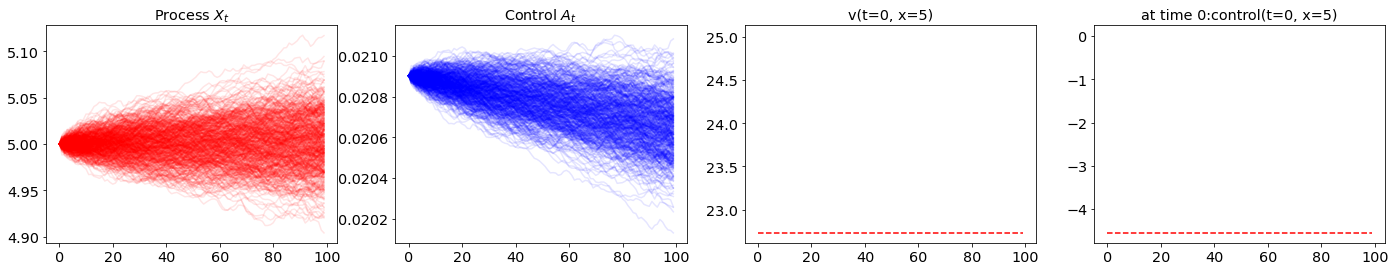

  1%|▍                                      | 100/10000 [00:13<19:13,  8.58it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.31 
 theoretical optimal control at time 0: -4.55


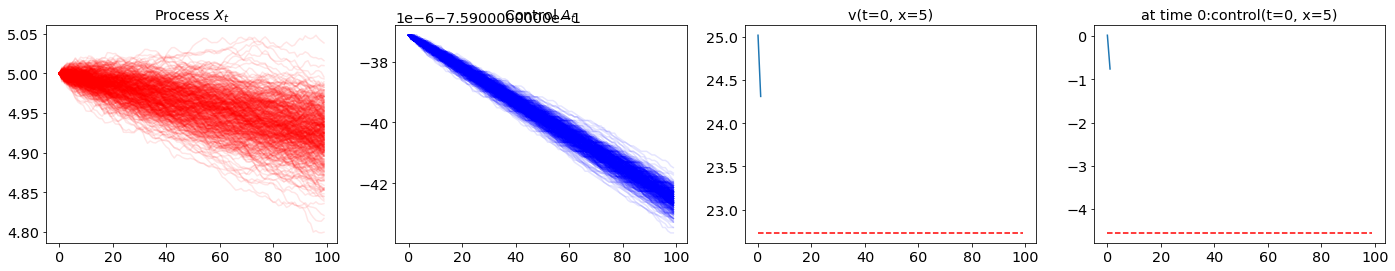

  2%|▊                                      | 200/10000 [00:26<18:54,  8.64it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.17 
 theoretical optimal control at time 0: -4.55


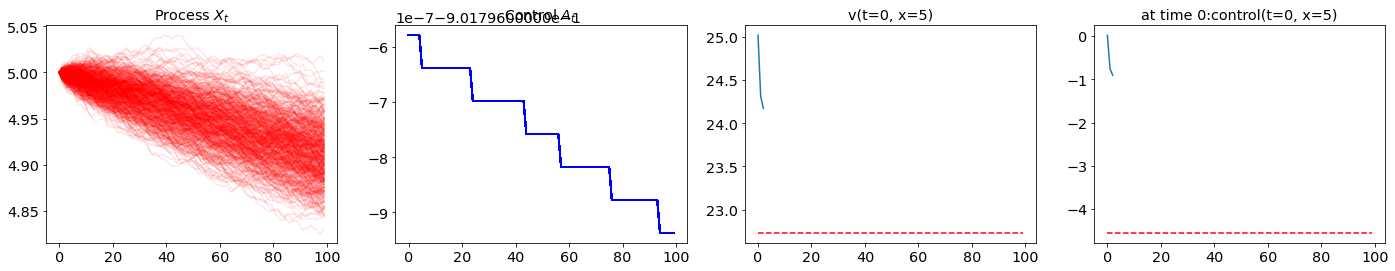

  3%|█▏                                     | 300/10000 [00:39<19:28,  8.30it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.15 
 theoretical optimal control at time 0: -4.55


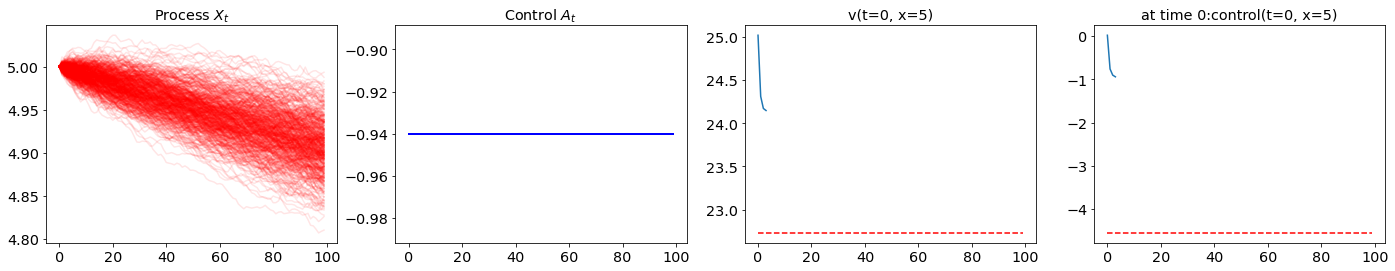

  4%|█▌                                     | 400/10000 [00:52<18:42,  8.55it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.15 
 theoretical optimal control at time 0: -4.55


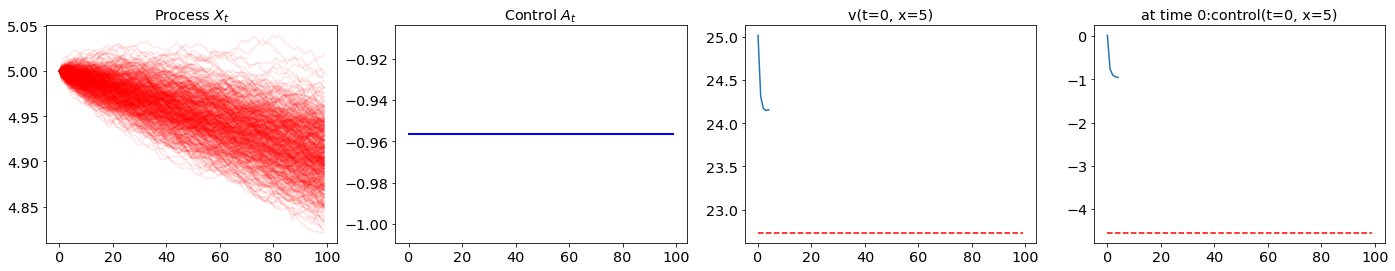

  5%|█▉                                     | 500/10000 [01:05<18:35,  8.51it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.12 
 theoretical optimal control at time 0: -4.55


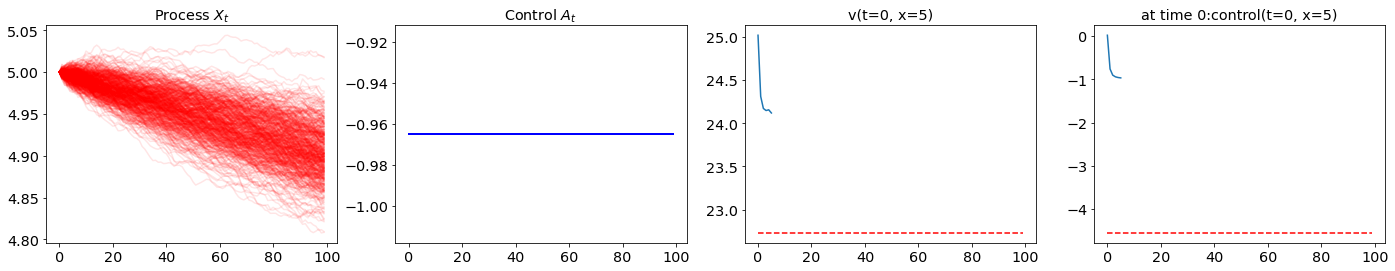

  6%|██▎                                    | 600/10000 [01:18<18:12,  8.60it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.12 
 theoretical optimal control at time 0: -4.55


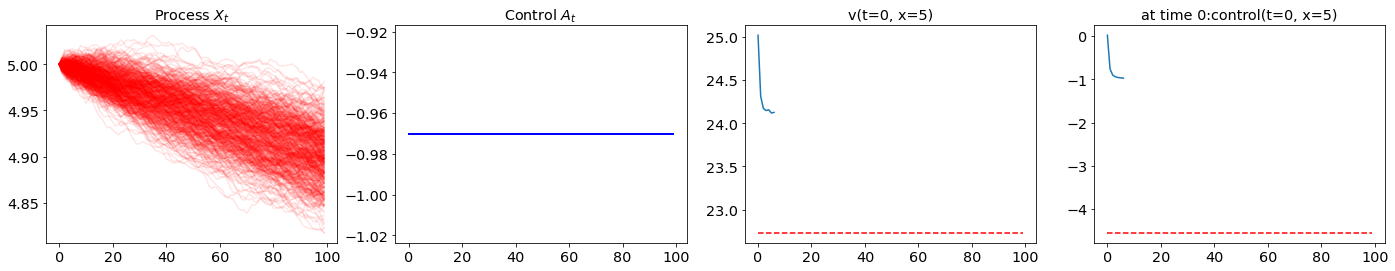

  7%|██▋                                    | 700/10000 [01:30<18:04,  8.58it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.13 
 theoretical optimal control at time 0: -4.55


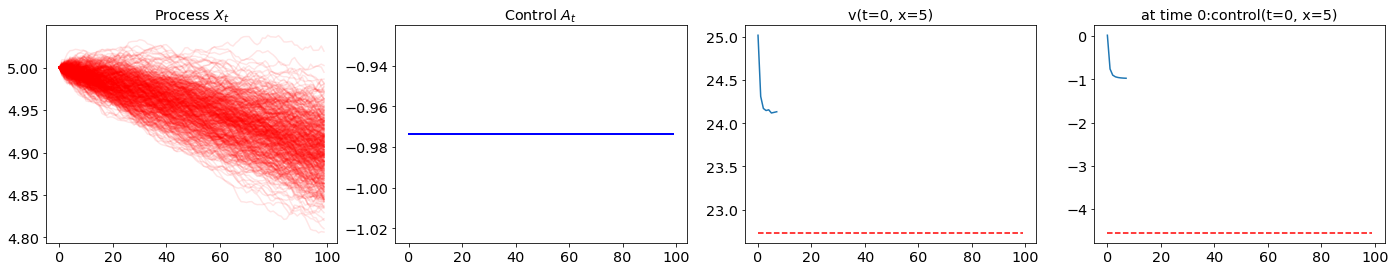

  8%|███                                    | 800/10000 [01:43<17:48,  8.61it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.13 
 theoretical optimal control at time 0: -4.55


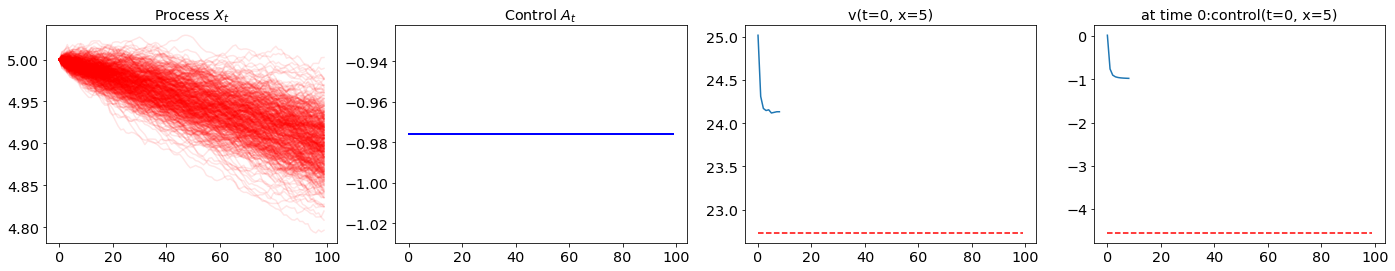

  9%|███▌                                   | 900/10000 [01:56<17:57,  8.45it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.13 
 theoretical optimal control at time 0: -4.55


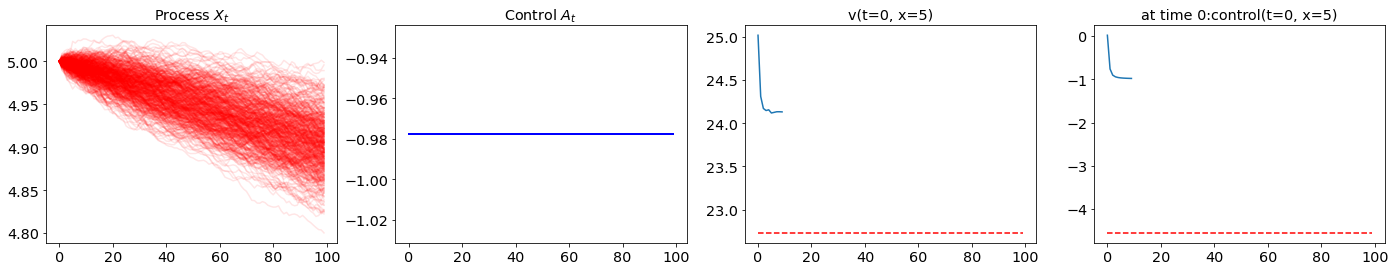

 10%|███▊                                  | 1000/10000 [02:09<17:37,  8.51it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.1 
 theoretical optimal control at time 0: -4.55


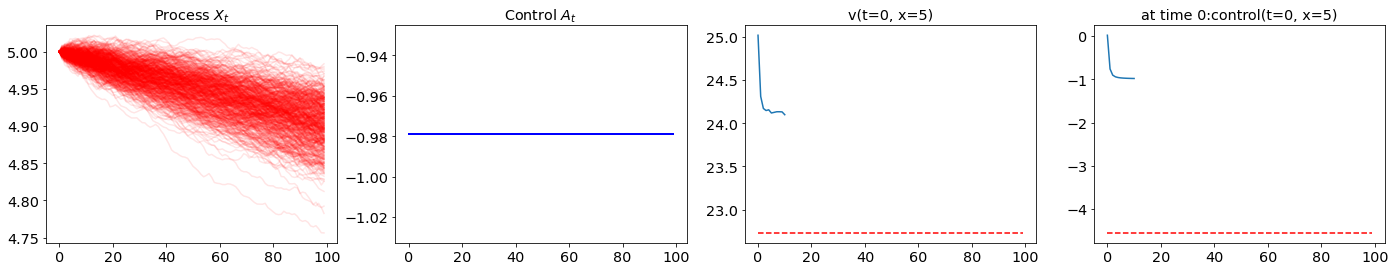

 11%|████▏                                 | 1100/10000 [02:22<17:23,  8.53it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.13 
 theoretical optimal control at time 0: -4.55


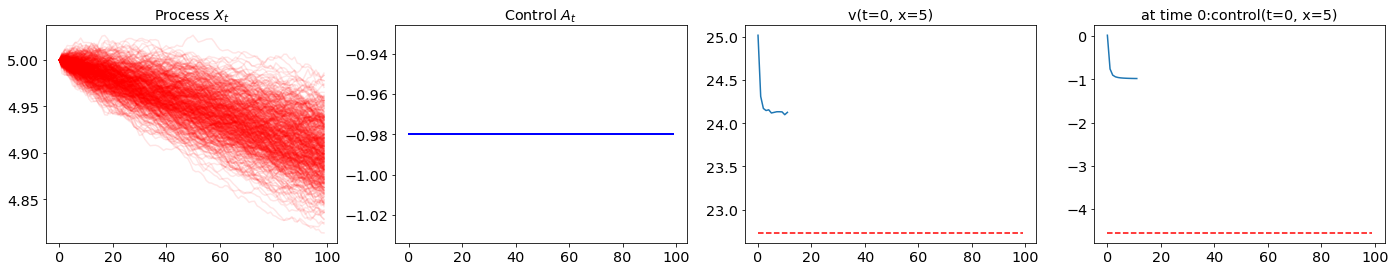

 12%|████▌                                 | 1200/10000 [02:35<16:19,  8.98it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.11 
 theoretical optimal control at time 0: -4.55


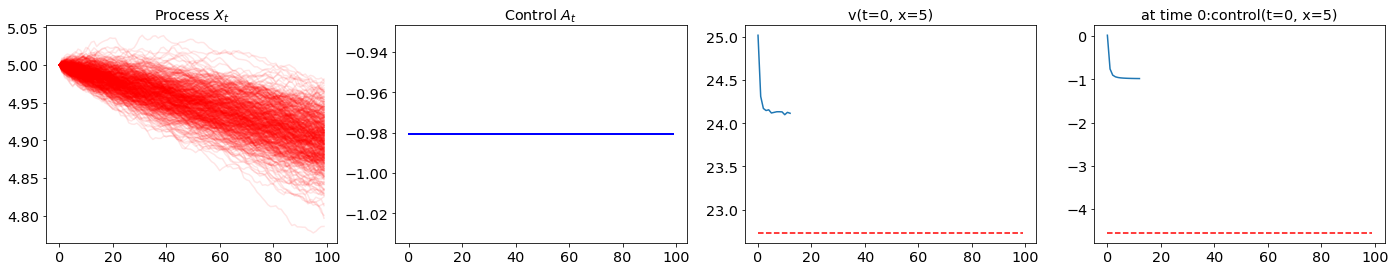

 13%|████▉                                 | 1300/10000 [02:47<16:10,  8.97it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.16 
 theoretical optimal control at time 0: -4.55


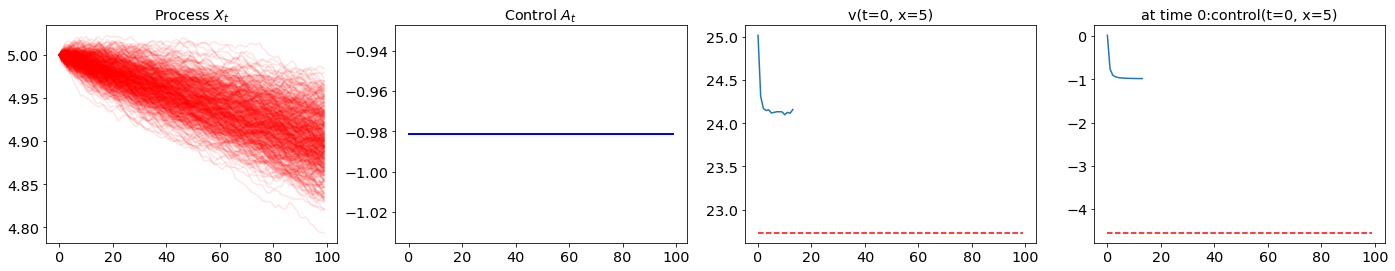

 14%|█████▎                                | 1400/10000 [02:59<16:04,  8.92it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.11 
 theoretical optimal control at time 0: -4.55


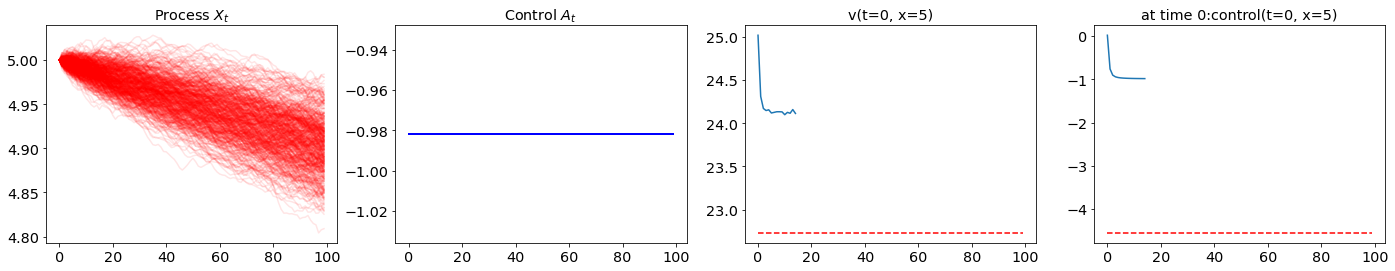

 15%|█████▋                                | 1500/10000 [03:11<15:57,  8.87it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.11 
 theoretical optimal control at time 0: -4.55


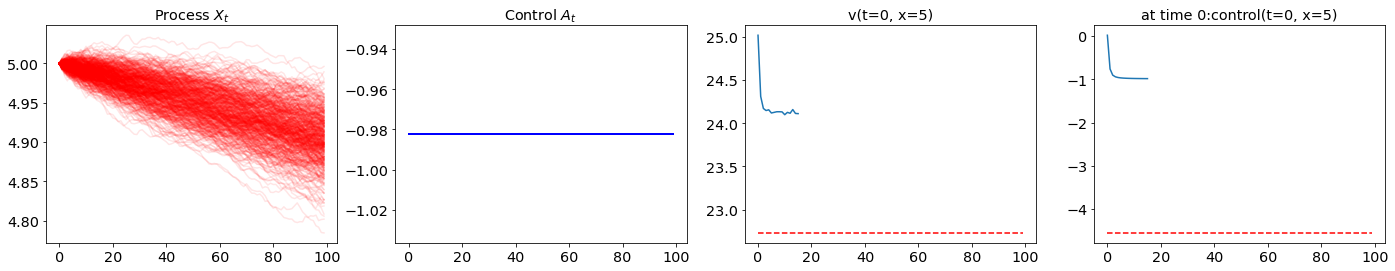

 16%|██████                                | 1600/10000 [03:24<15:34,  8.99it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.13 
 theoretical optimal control at time 0: -4.55


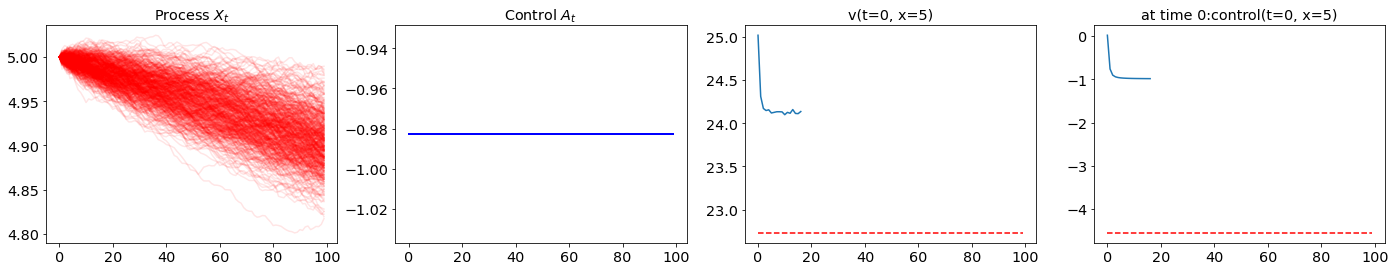

 17%|██████▍                               | 1700/10000 [03:36<15:26,  8.96it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.14 
 theoretical optimal control at time 0: -4.55


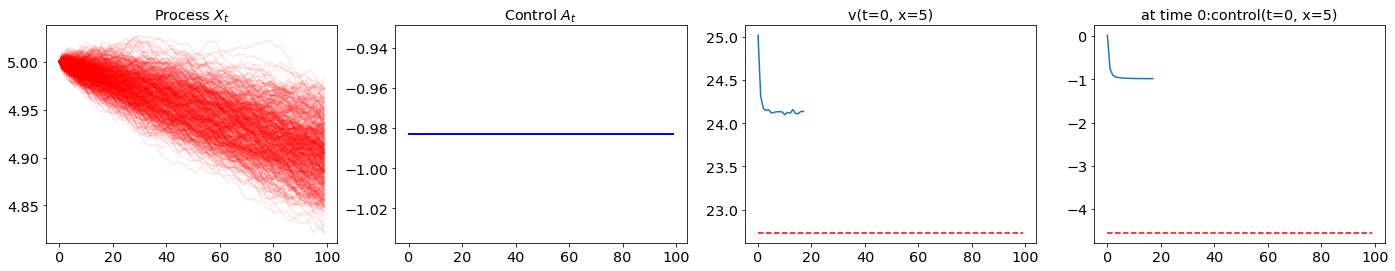

 18%|██████▊                               | 1800/10000 [03:48<15:19,  8.92it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.14 
 theoretical optimal control at time 0: -4.55


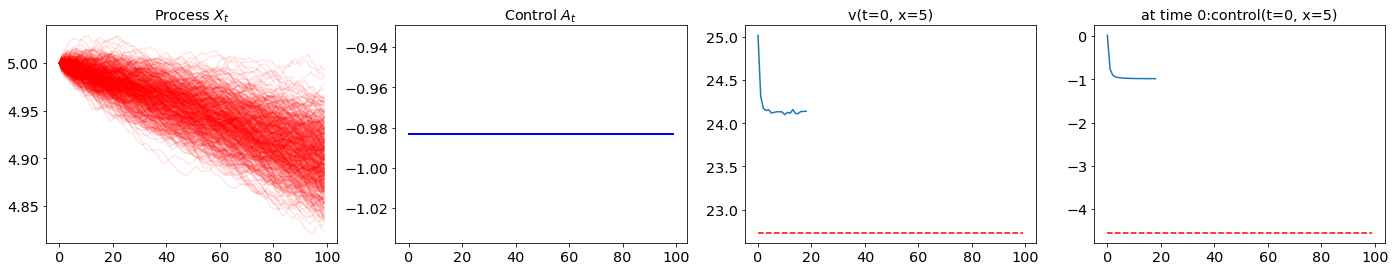

 19%|███████▏                              | 1900/10000 [04:00<15:09,  8.91it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.1 
 theoretical optimal control at time 0: -4.55


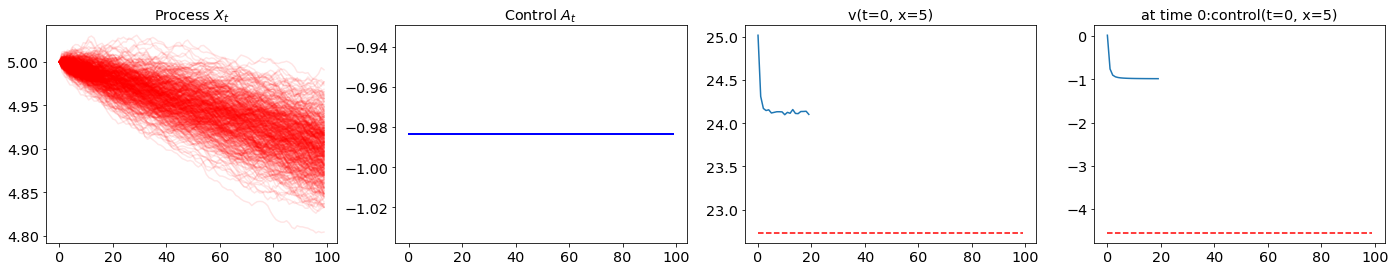

 20%|███████▌                              | 2000/10000 [04:13<14:54,  8.95it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.12 
 theoretical optimal control at time 0: -4.55


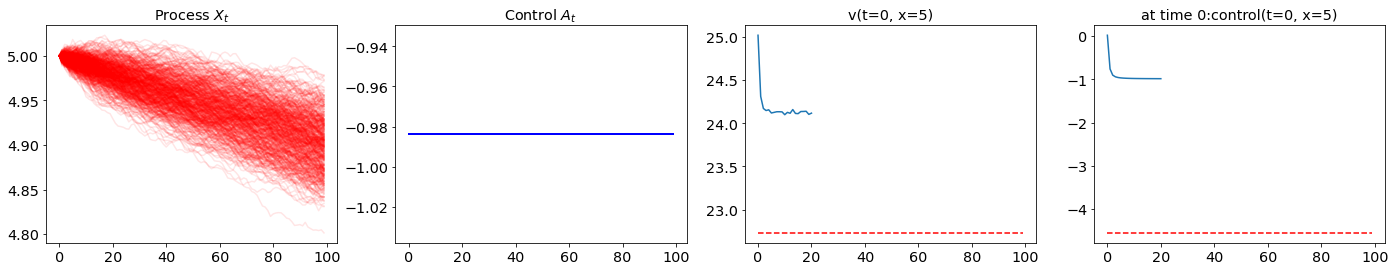

 21%|███████▉                              | 2100/10000 [04:25<14:39,  8.98it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.11 
 theoretical optimal control at time 0: -4.55


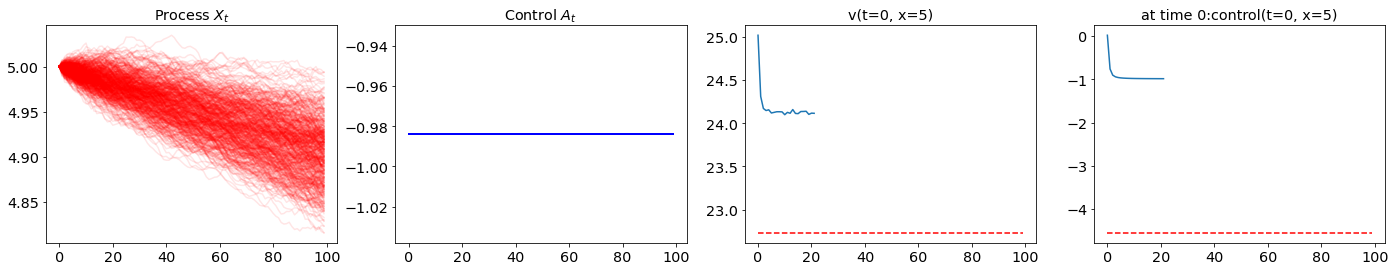

 22%|████████▎                             | 2200/10000 [04:37<14:43,  8.83it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.12 
 theoretical optimal control at time 0: -4.55


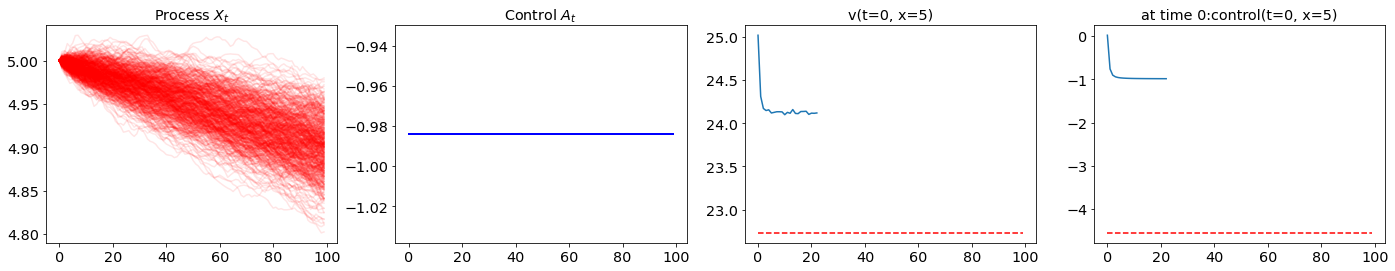

 23%|████████▋                             | 2300/10000 [04:49<14:21,  8.93it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.1 
 theoretical optimal control at time 0: -4.55


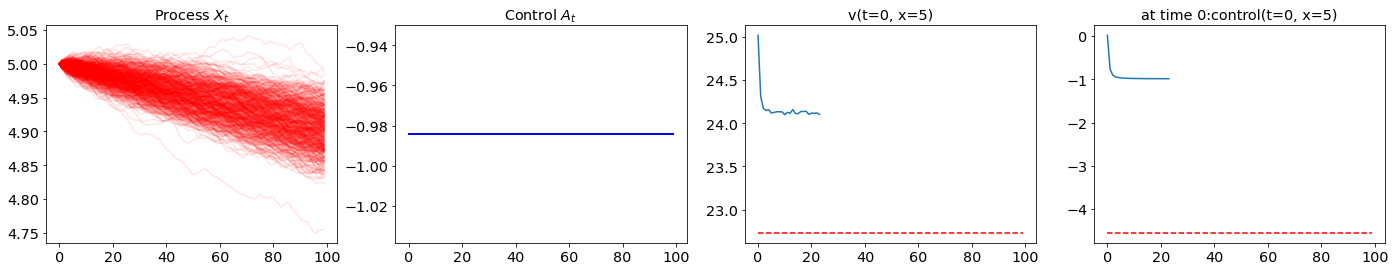

 24%|█████████                             | 2400/10000 [05:02<13:54,  9.11it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.13 
 theoretical optimal control at time 0: -4.55


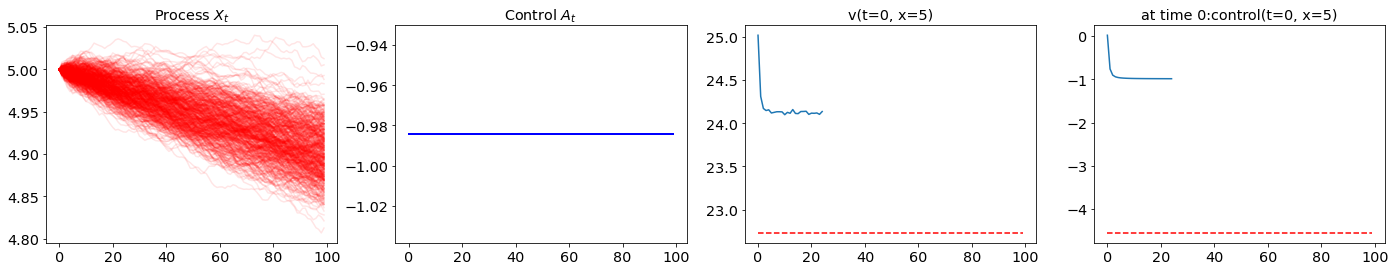

 25%|█████████▌                            | 2500/10000 [05:14<13:55,  8.98it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.1 
 theoretical optimal control at time 0: -4.55


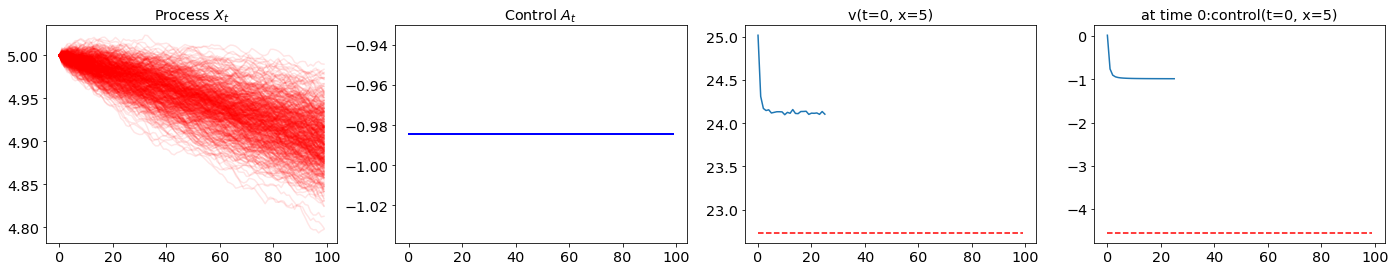

 26%|█████████▉                            | 2600/10000 [05:26<13:43,  8.98it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.13 
 theoretical optimal control at time 0: -4.55


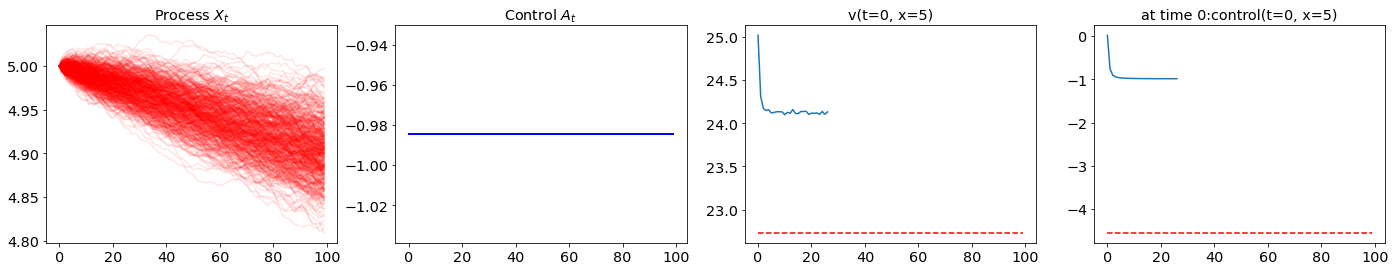

 27%|██████████▎                           | 2700/10000 [05:38<13:20,  9.12it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.1 
 theoretical optimal control at time 0: -4.55


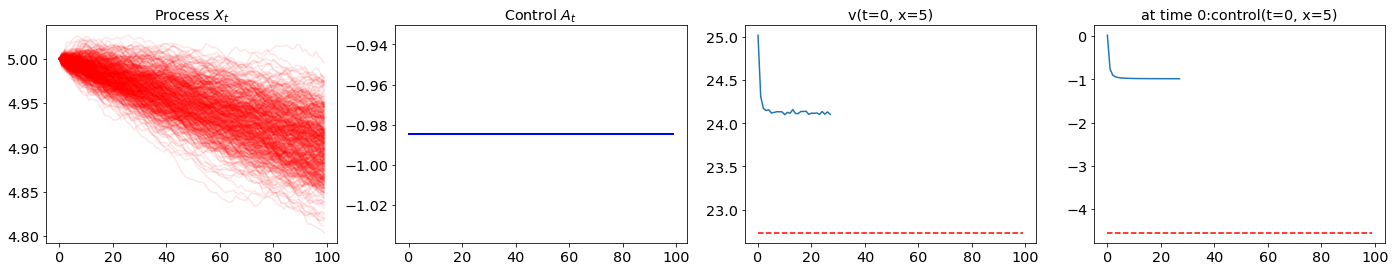

 28%|██████████▋                           | 2800/10000 [05:50<13:23,  8.96it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.12 
 theoretical optimal control at time 0: -4.55


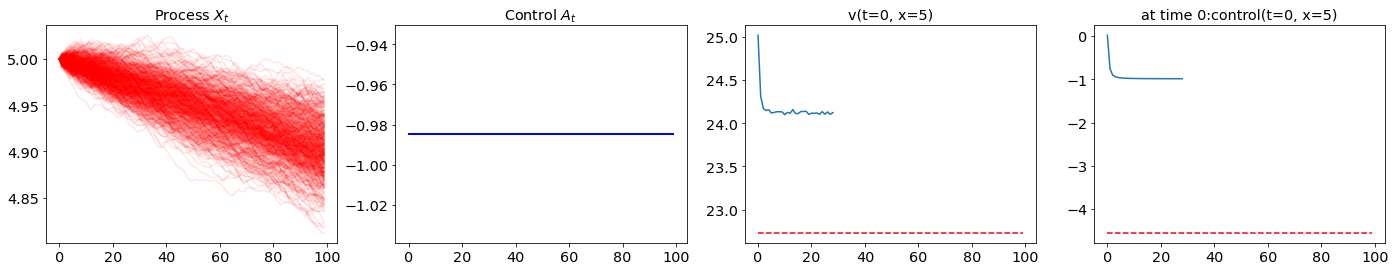

 29%|███████████                           | 2900/10000 [06:02<12:59,  9.11it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.12 
 theoretical optimal control at time 0: -4.55


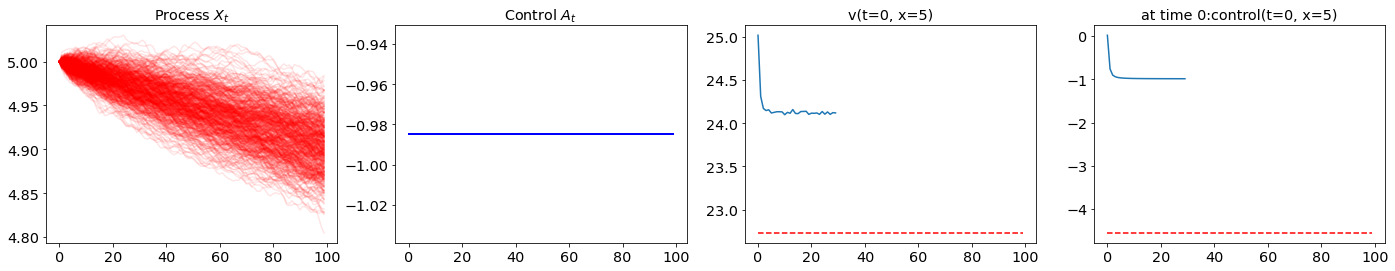

 30%|███████████▍                          | 3000/10000 [06:15<12:56,  9.01it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.11 
 theoretical optimal control at time 0: -4.55


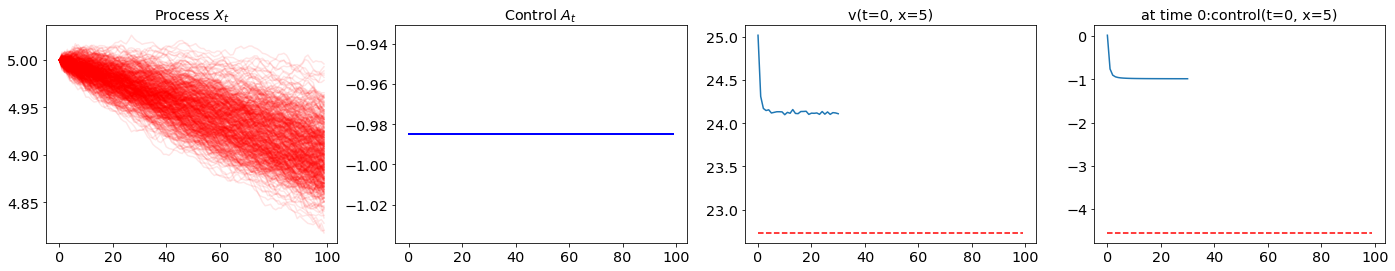

 31%|███████████▊                          | 3100/10000 [06:27<12:52,  8.93it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.13 
 theoretical optimal control at time 0: -4.55


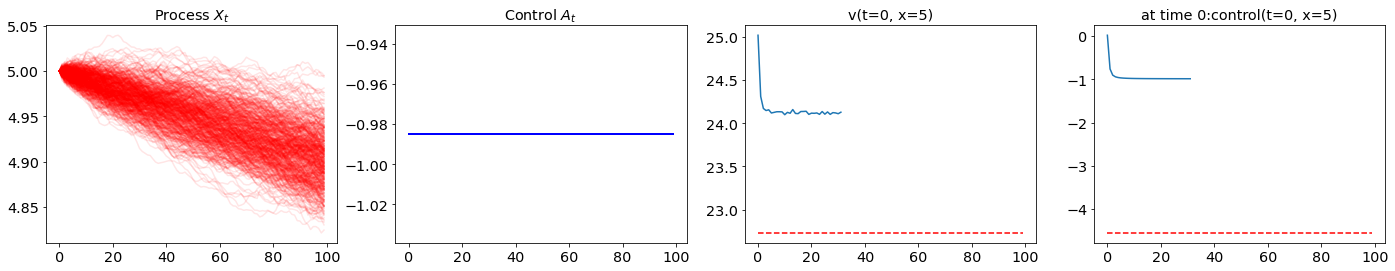

 32%|████████████▏                         | 3200/10000 [06:39<12:37,  8.98it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.16 
 theoretical optimal control at time 0: -4.55


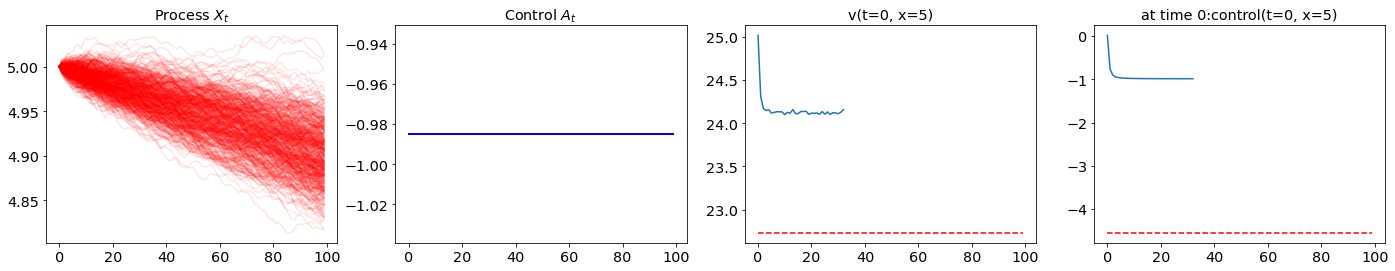

 33%|████████████▌                         | 3300/10000 [06:51<12:39,  8.82it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.15 
 theoretical optimal control at time 0: -4.55


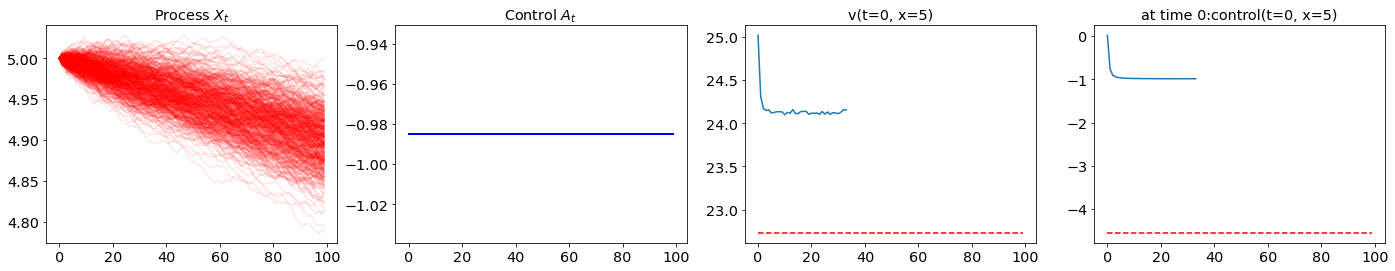

 34%|████████████▉                         | 3400/10000 [07:03<12:14,  8.98it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.09 
 theoretical optimal control at time 0: -4.55


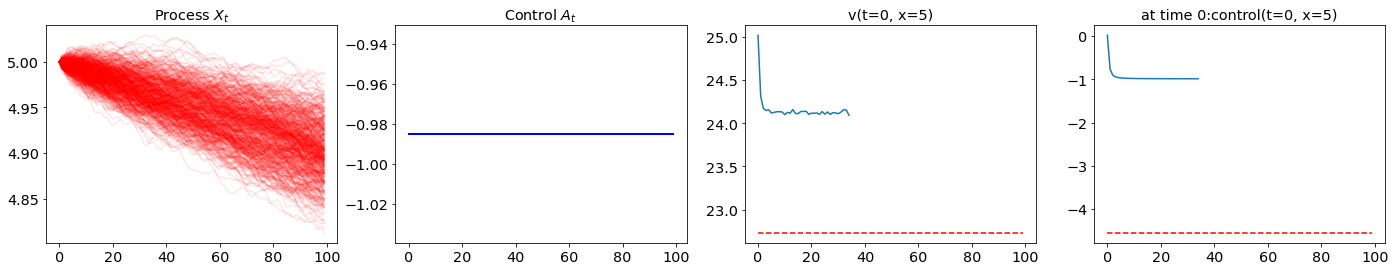

 35%|█████████████▎                        | 3500/10000 [07:16<12:26,  8.71it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.11 
 theoretical optimal control at time 0: -4.55


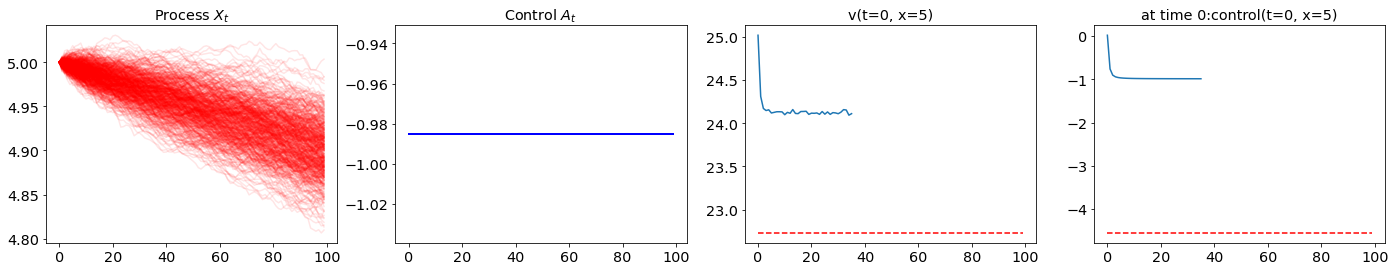

 36%|█████████████▋                        | 3600/10000 [07:28<11:39,  9.15it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.11 
 theoretical optimal control at time 0: -4.55


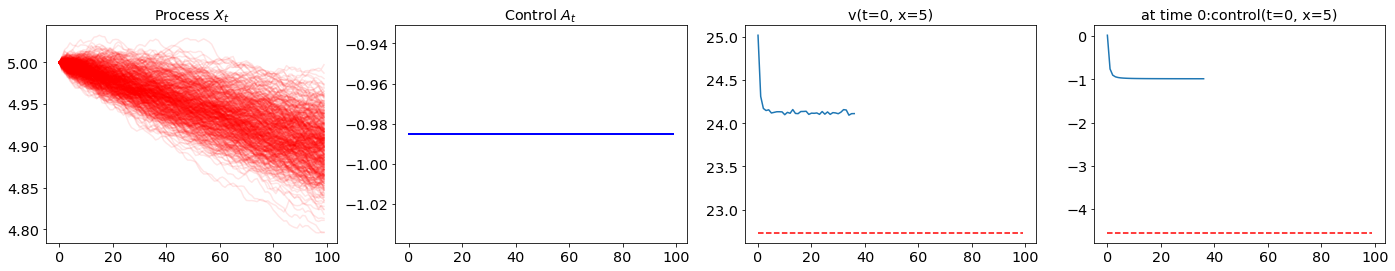

 37%|██████████████                        | 3700/10000 [07:40<11:40,  9.00it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.12 
 theoretical optimal control at time 0: -4.55


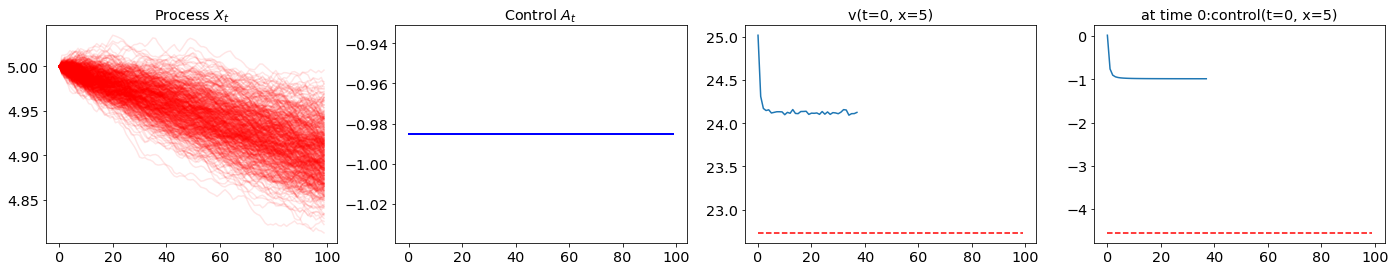

 38%|██████████████▍                       | 3800/10000 [07:52<11:34,  8.93it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.11 
 theoretical optimal control at time 0: -4.55


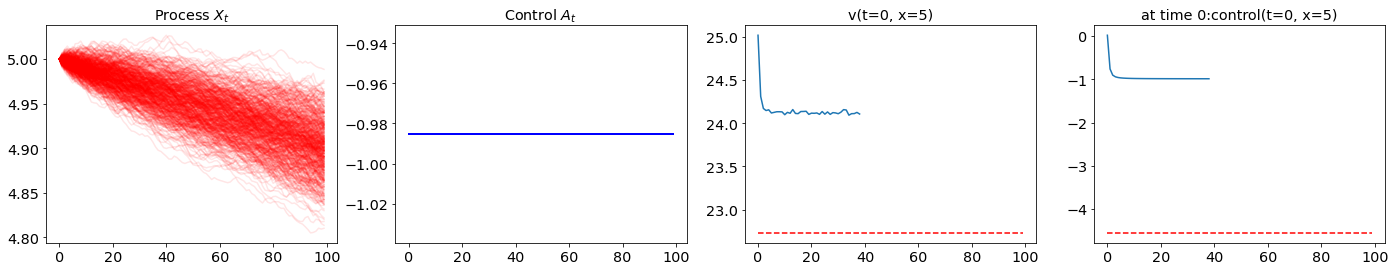

 39%|██████████████▊                       | 3900/10000 [08:04<11:08,  9.12it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.11 
 theoretical optimal control at time 0: -4.55


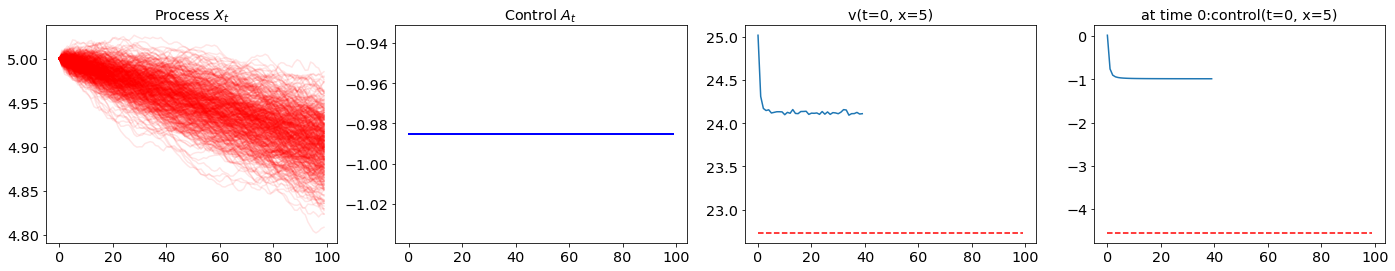

 40%|███████████████▏                      | 4000/10000 [08:16<11:21,  8.81it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.14 
 theoretical optimal control at time 0: -4.55


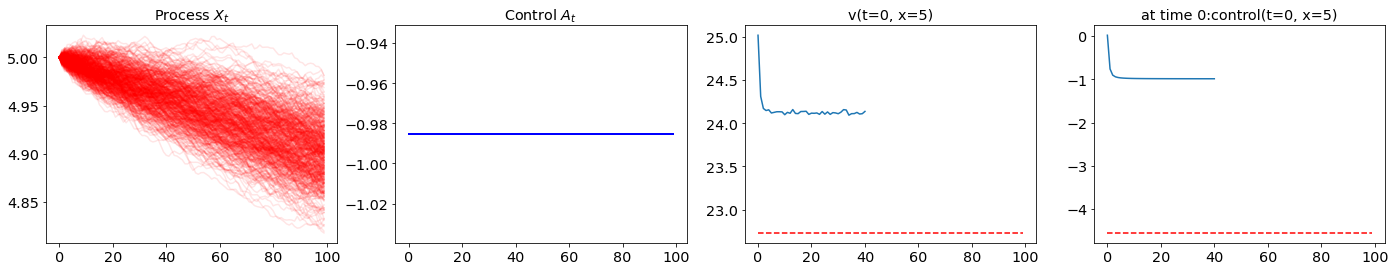

 41%|███████████████▌                      | 4100/10000 [08:29<10:58,  8.96it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.1 
 theoretical optimal control at time 0: -4.55


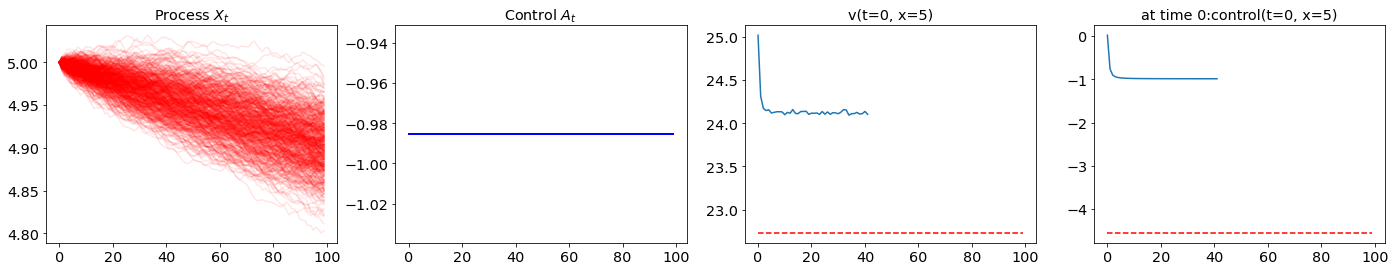

 42%|███████████████▉                      | 4200/10000 [08:41<10:43,  9.01it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.13 
 theoretical optimal control at time 0: -4.55


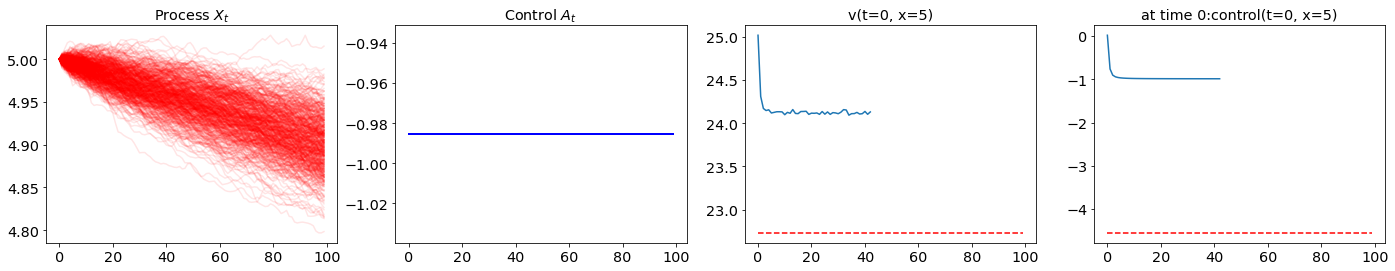

 43%|████████████████▎                     | 4300/10000 [08:53<10:38,  8.93it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.14 
 theoretical optimal control at time 0: -4.55


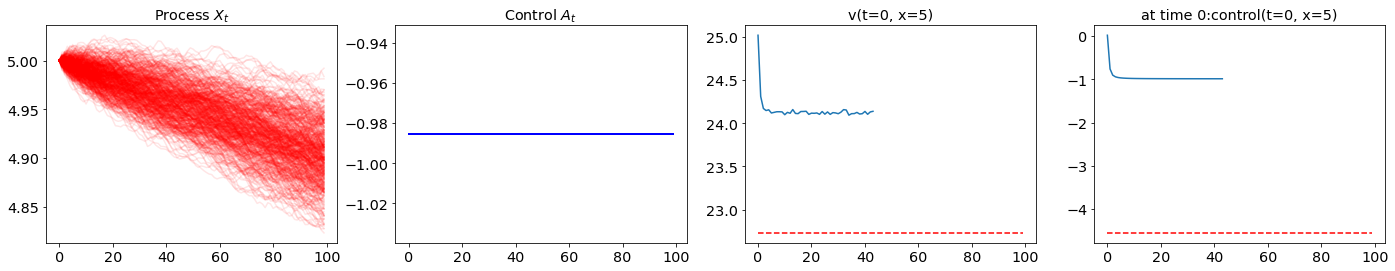

 44%|████████████████▋                     | 4400/10000 [09:05<10:28,  8.92it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.11 
 theoretical optimal control at time 0: -4.55


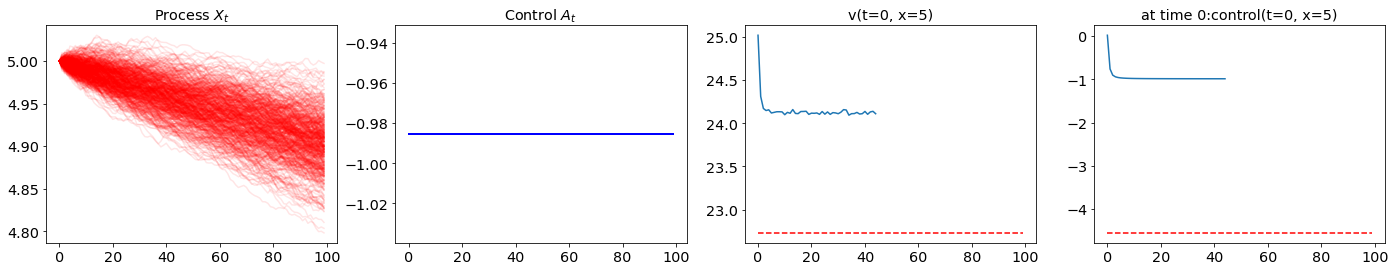

 45%|█████████████████                     | 4500/10000 [09:17<10:12,  8.97it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.12 
 theoretical optimal control at time 0: -4.55


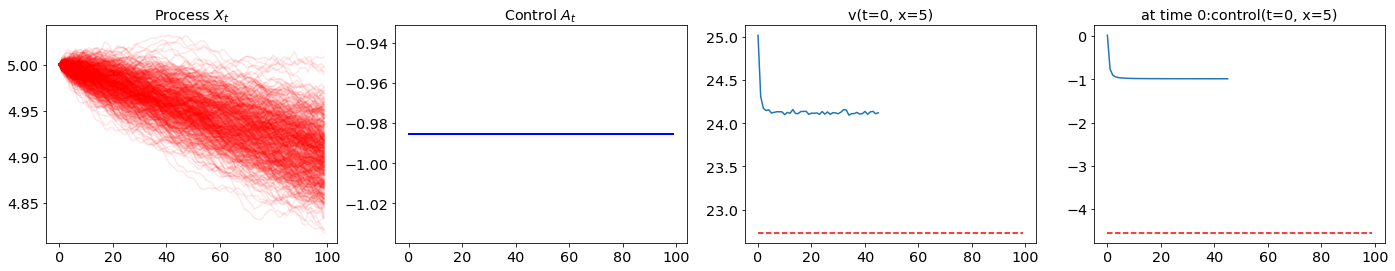

 46%|█████████████████▍                    | 4600/10000 [09:30<10:02,  8.96it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.11 
 theoretical optimal control at time 0: -4.55


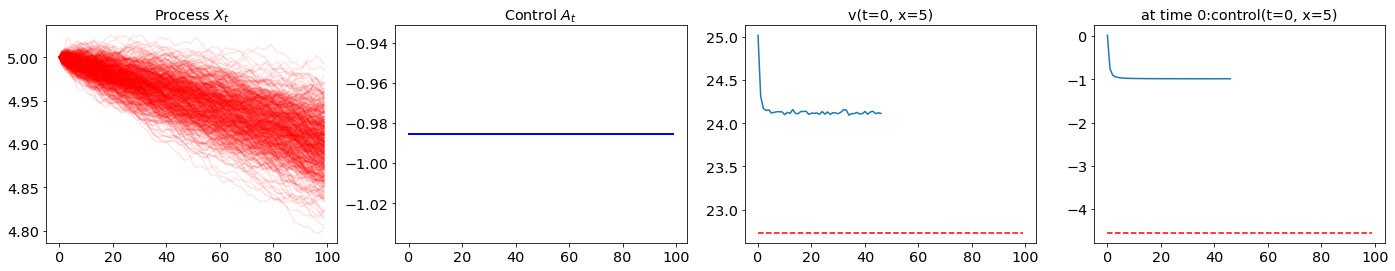

 47%|█████████████████▊                    | 4700/10000 [09:42<09:48,  9.00it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.1 
 theoretical optimal control at time 0: -4.55


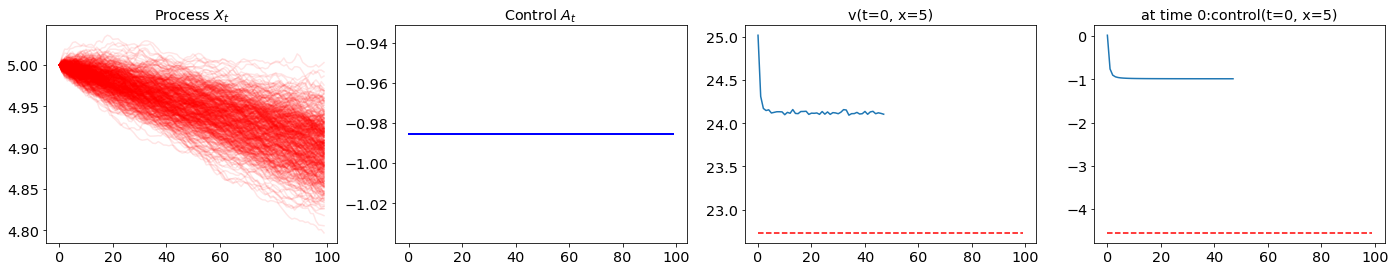

 48%|██████████████████▏                   | 4800/10000 [09:54<09:38,  8.99it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.12 
 theoretical optimal control at time 0: -4.55


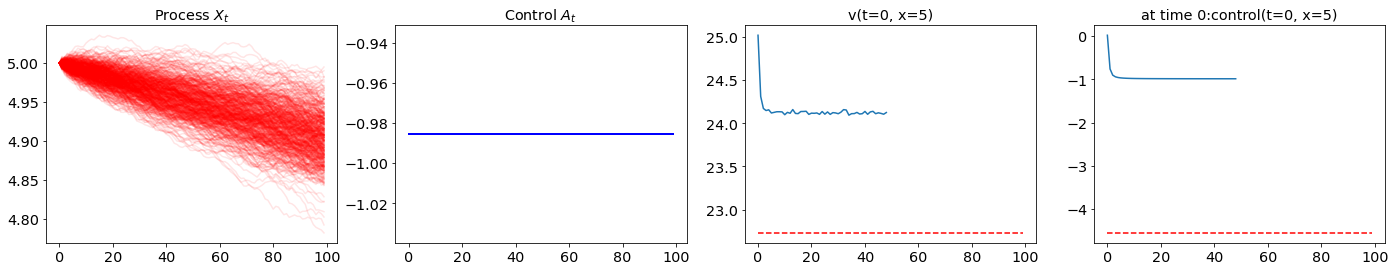

 49%|██████████████████▌                   | 4900/10000 [10:06<09:32,  8.92it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.15 
 theoretical optimal control at time 0: -4.55


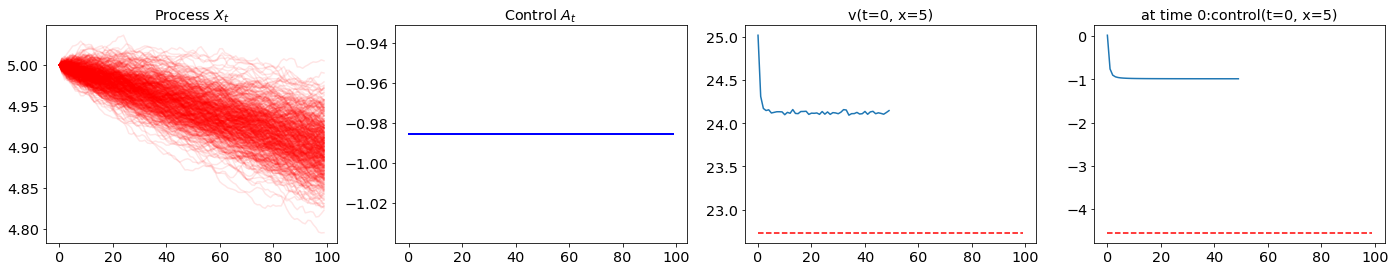

 50%|███████████████████                   | 5000/10000 [10:19<09:07,  9.13it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.11 
 theoretical optimal control at time 0: -4.55


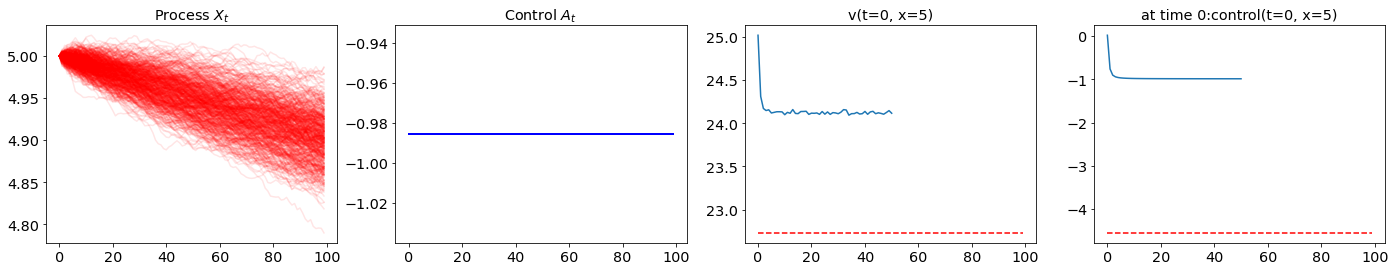

 51%|███████████████████▍                  | 5100/10000 [10:31<08:57,  9.12it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.12 
 theoretical optimal control at time 0: -4.55


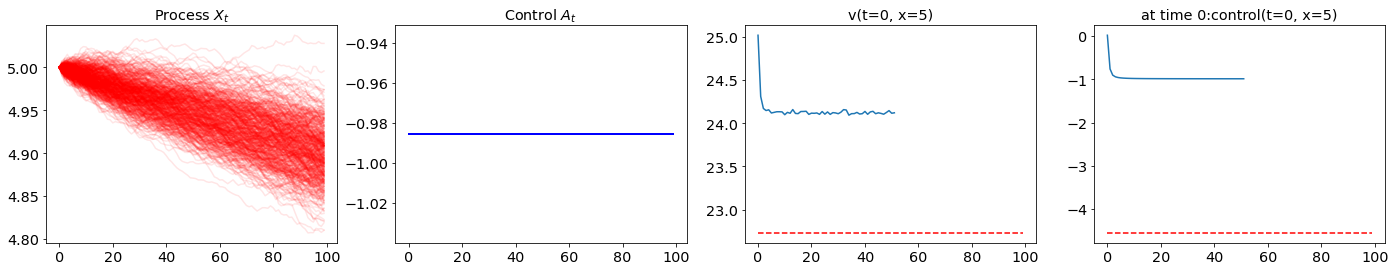

 52%|███████████████████▊                  | 5200/10000 [10:43<08:58,  8.91it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.13 
 theoretical optimal control at time 0: -4.55


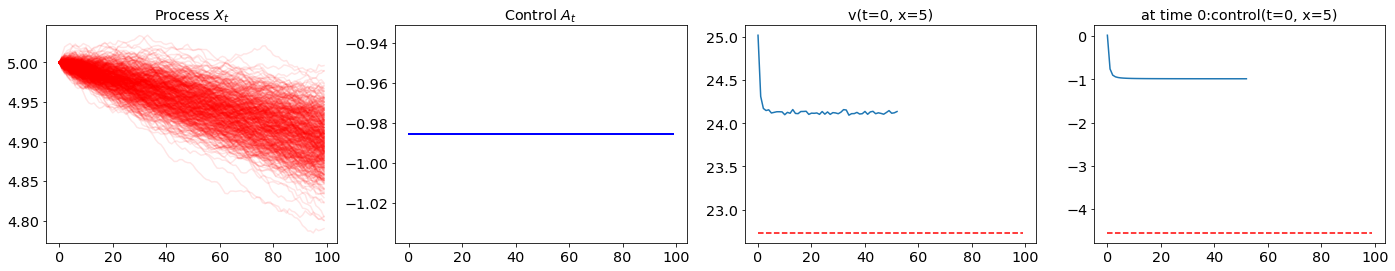

 53%|████████████████████▏                 | 5300/10000 [10:55<08:47,  8.91it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.12 
 theoretical optimal control at time 0: -4.55


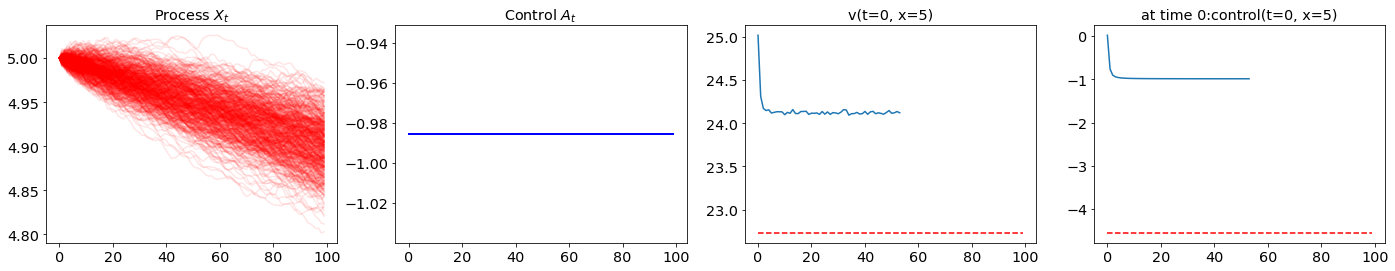

 54%|████████████████████▌                 | 5400/10000 [11:07<08:35,  8.93it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.12 
 theoretical optimal control at time 0: -4.55


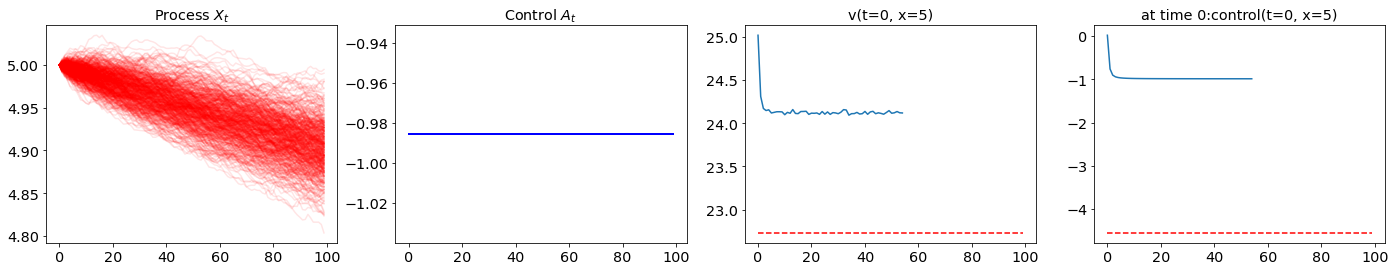

 55%|████████████████████▉                 | 5500/10000 [11:19<08:18,  9.02it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.13 
 theoretical optimal control at time 0: -4.55


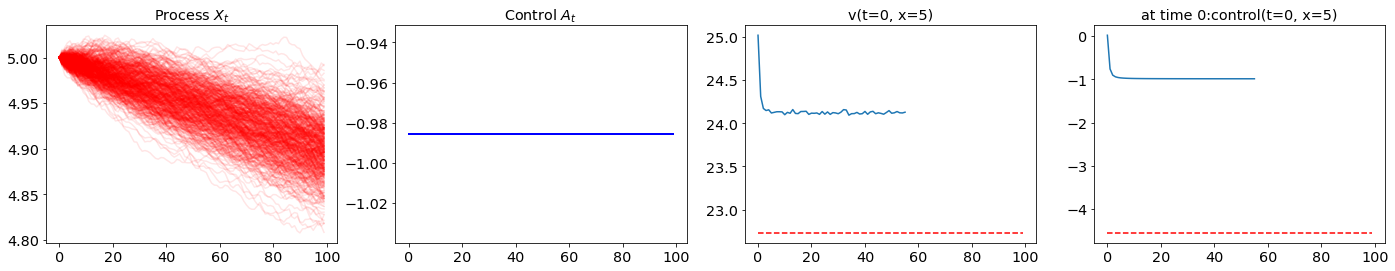

 56%|█████████████████████▎                | 5600/10000 [11:32<08:11,  8.95it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.11 
 theoretical optimal control at time 0: -4.55


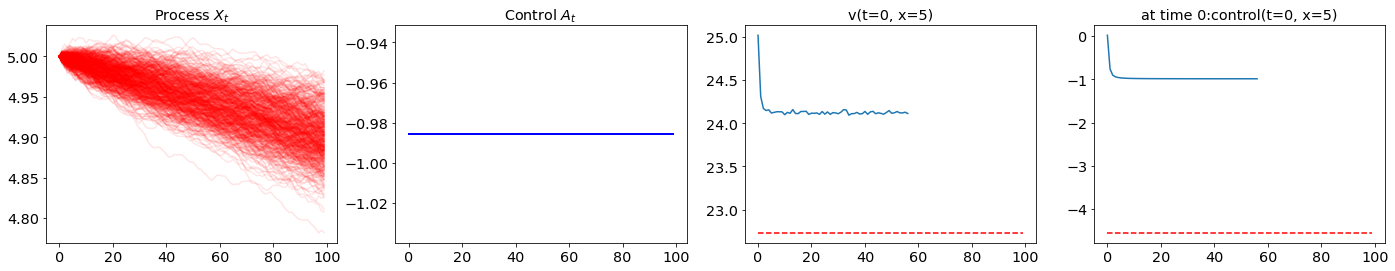

 57%|█████████████████████▋                | 5700/10000 [11:44<07:52,  9.10it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.12 
 theoretical optimal control at time 0: -4.55


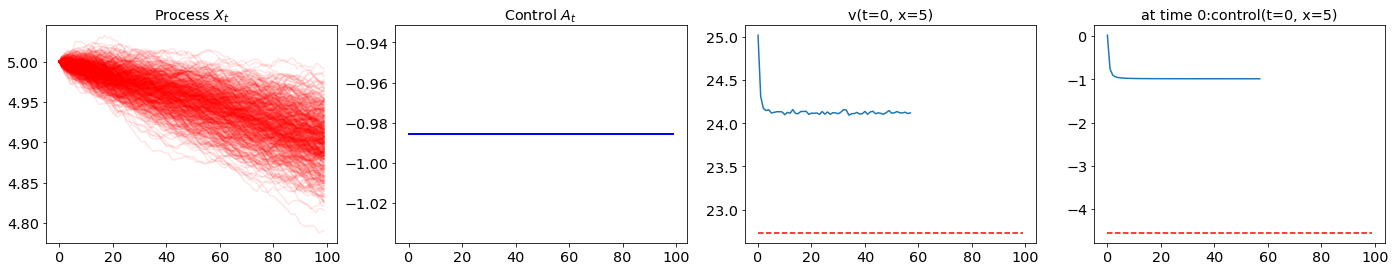

 58%|██████████████████████                | 5800/10000 [11:56<07:54,  8.85it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.14 
 theoretical optimal control at time 0: -4.55


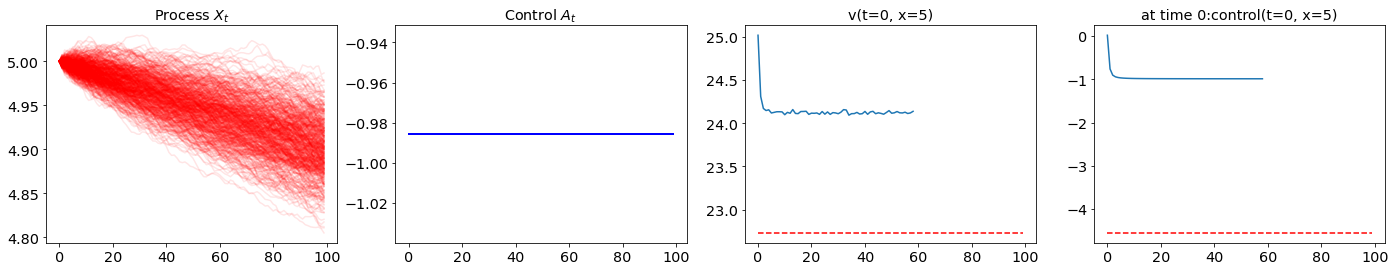

 59%|██████████████████████▍               | 5900/10000 [12:08<07:38,  8.93it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.11 
 theoretical optimal control at time 0: -4.55


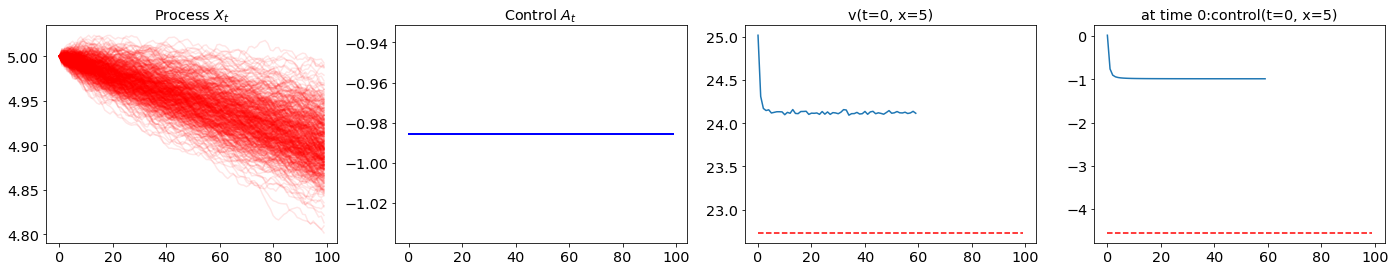

 60%|██████████████████████▊               | 6000/10000 [12:20<07:24,  9.00it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.13 
 theoretical optimal control at time 0: -4.55


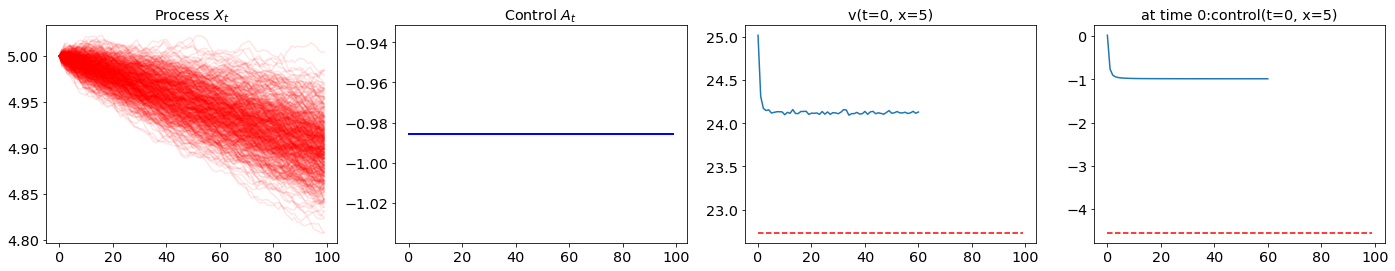

 61%|███████████████████████▏              | 6100/10000 [12:32<07:20,  8.86it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.12 
 theoretical optimal control at time 0: -4.55


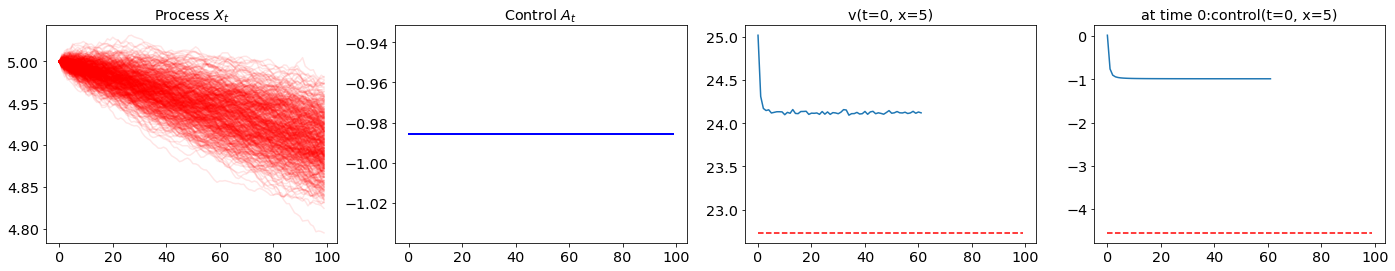

 62%|███████████████████████▌              | 6200/10000 [12:45<07:02,  9.00it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.14 
 theoretical optimal control at time 0: -4.55


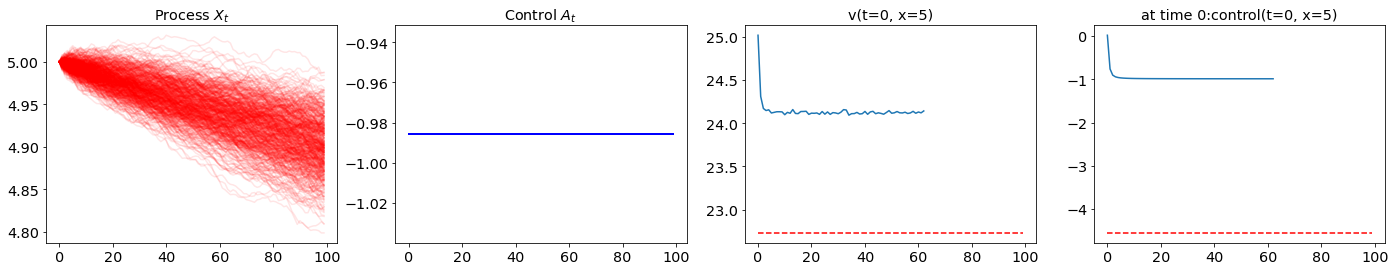

 63%|███████████████████████▉              | 6300/10000 [12:57<06:53,  8.96it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.12 
 theoretical optimal control at time 0: -4.55


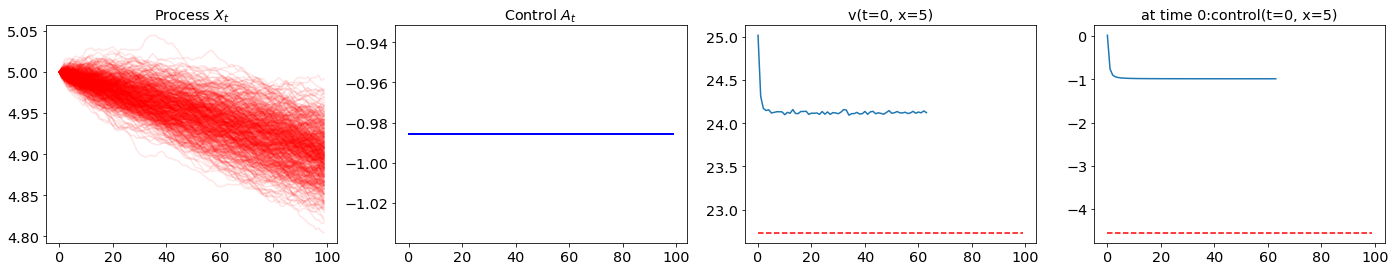

 64%|████████████████████████▎             | 6400/10000 [13:09<06:42,  8.95it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.11 
 theoretical optimal control at time 0: -4.55


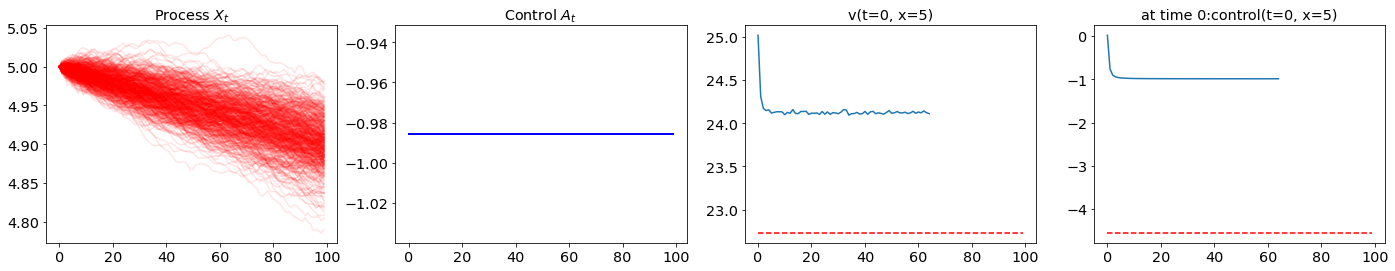

 65%|████████████████████████▋             | 6500/10000 [13:21<06:32,  8.93it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.14 
 theoretical optimal control at time 0: -4.55


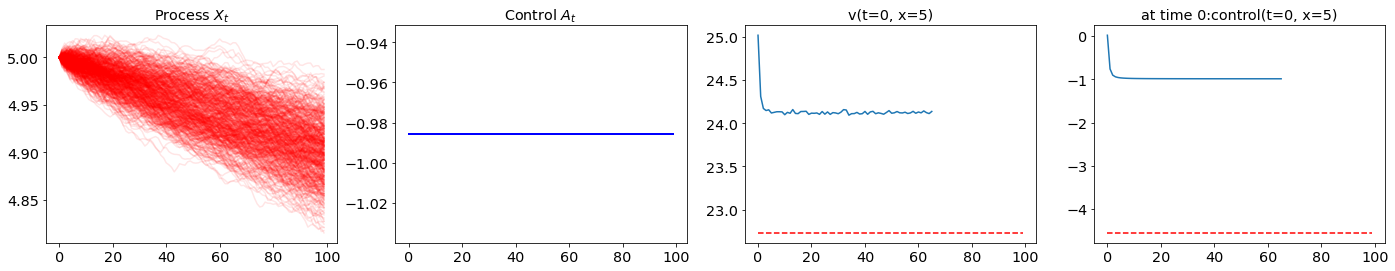

 66%|█████████████████████████             | 6600/10000 [13:33<06:12,  9.12it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.12 
 theoretical optimal control at time 0: -4.55


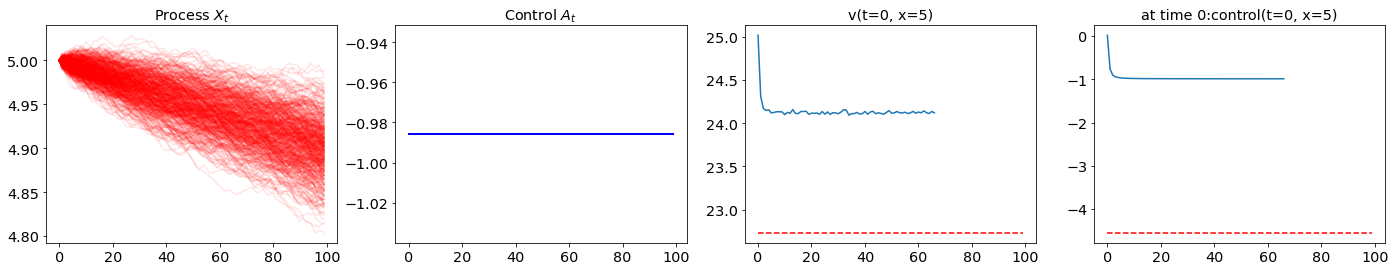

 67%|█████████████████████████▍            | 6700/10000 [13:46<06:05,  9.03it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.14 
 theoretical optimal control at time 0: -4.55


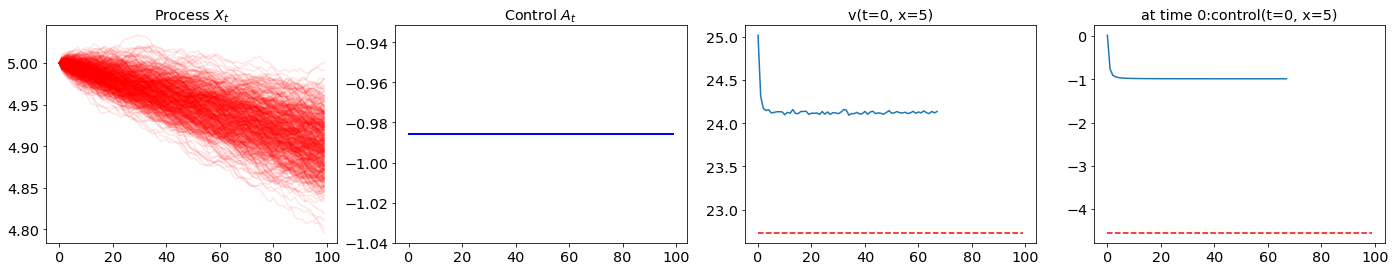

 68%|█████████████████████████▊            | 6800/10000 [13:58<05:57,  8.95it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.12 
 theoretical optimal control at time 0: -4.55


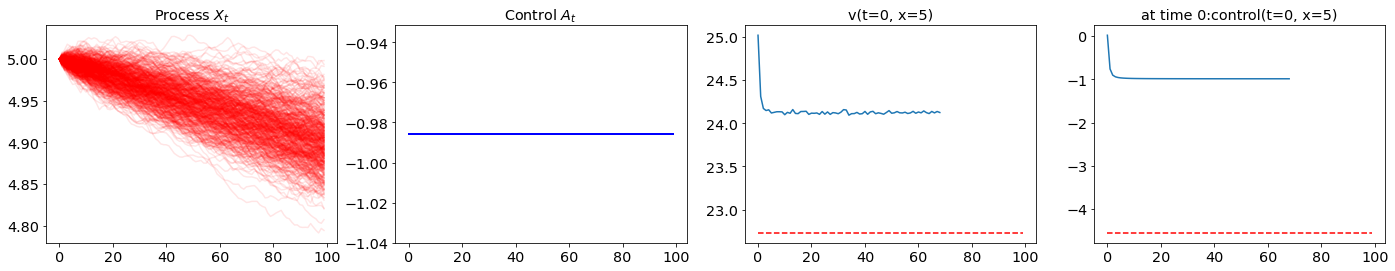

 69%|██████████████████████████▏           | 6900/10000 [14:10<05:46,  8.96it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.13 
 theoretical optimal control at time 0: -4.55


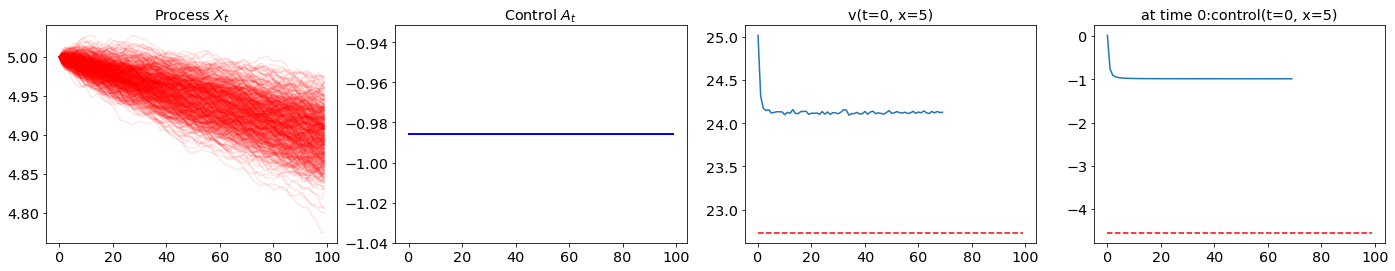

 70%|██████████████████████████▌           | 7000/10000 [14:22<05:34,  8.98it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.13 
 theoretical optimal control at time 0: -4.55


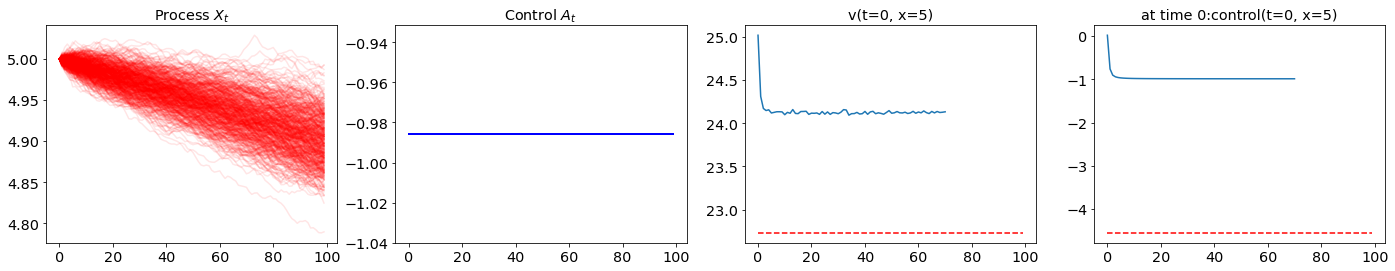

 71%|██████████████████████████▉           | 7100/10000 [14:34<05:18,  9.10it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.14 
 theoretical optimal control at time 0: -4.55


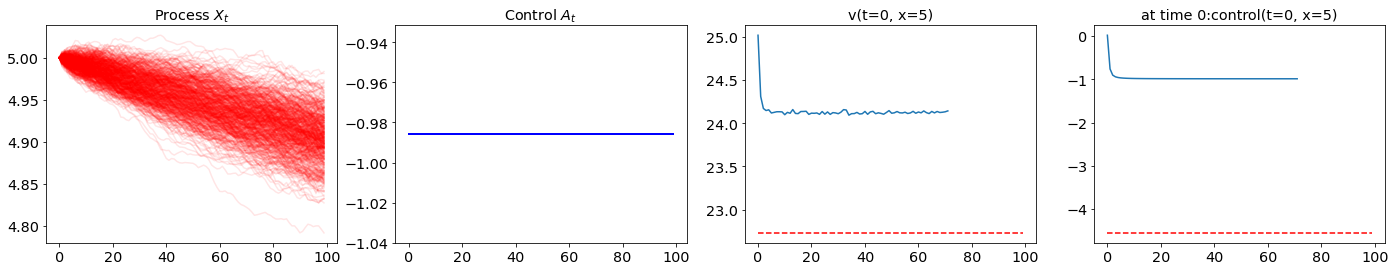

 72%|███████████████████████████▎          | 7200/10000 [14:46<05:10,  9.02it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.13 
 theoretical optimal control at time 0: -4.55


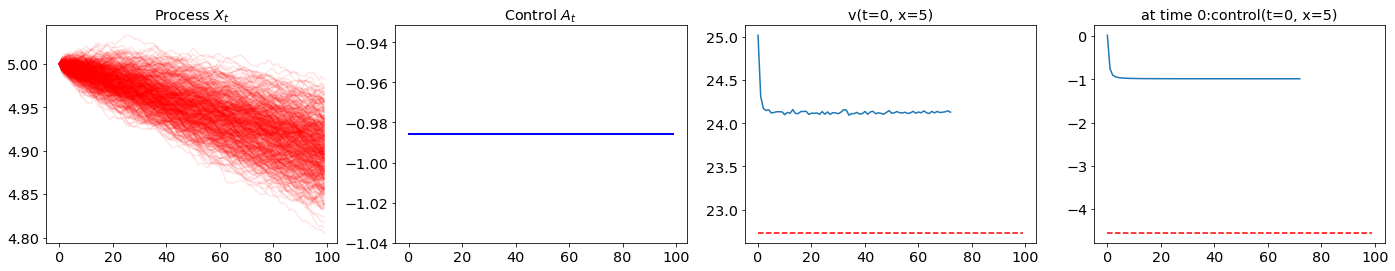

 73%|███████████████████████████▋          | 7300/10000 [14:59<05:03,  8.90it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.11 
 theoretical optimal control at time 0: -4.55


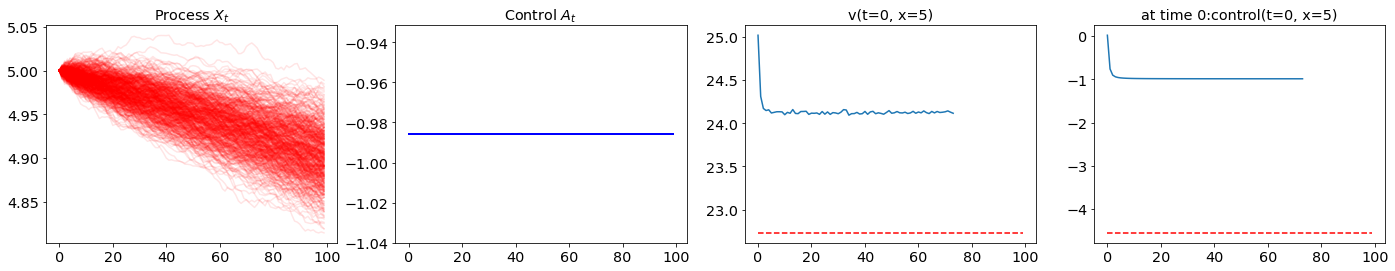

 74%|████████████████████████████          | 7400/10000 [15:11<04:52,  8.89it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.12 
 theoretical optimal control at time 0: -4.55


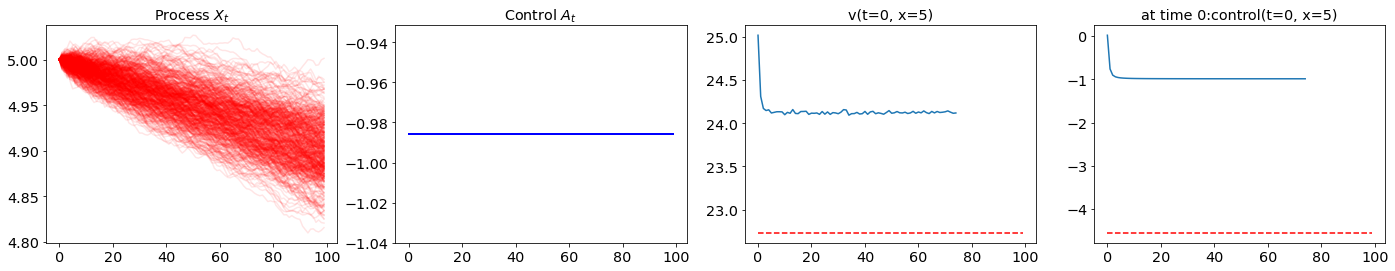

 75%|████████████████████████████▌         | 7500/10000 [15:23<04:36,  9.03it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.13 
 theoretical optimal control at time 0: -4.55


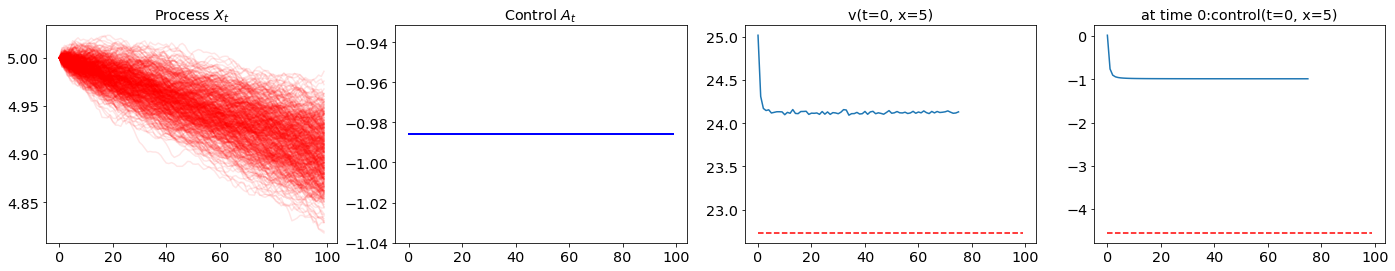

 76%|████████████████████████████▉         | 7600/10000 [15:35<04:25,  9.05it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.15 
 theoretical optimal control at time 0: -4.55


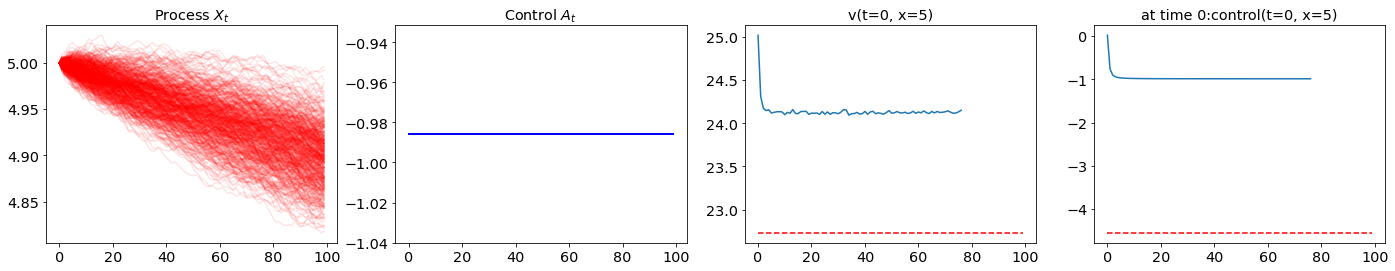

 77%|█████████████████████████████▎        | 7700/10000 [15:47<04:16,  8.97it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.1 
 theoretical optimal control at time 0: -4.55


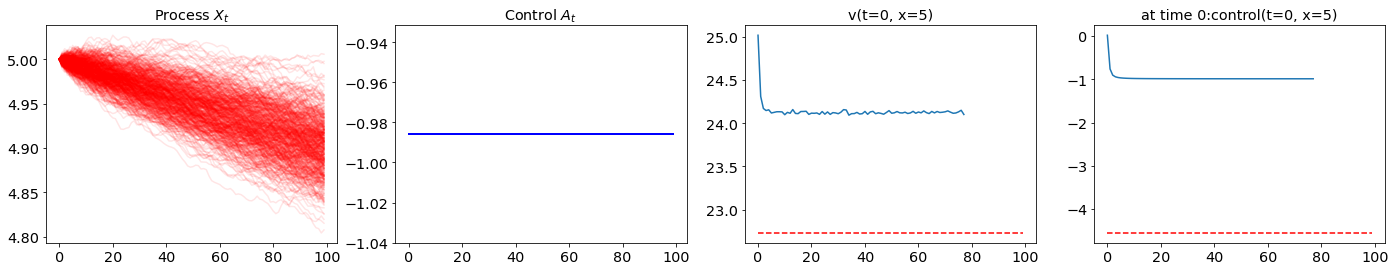

 78%|█████████████████████████████▋        | 7800/10000 [16:00<04:05,  8.97it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.13 
 theoretical optimal control at time 0: -4.55


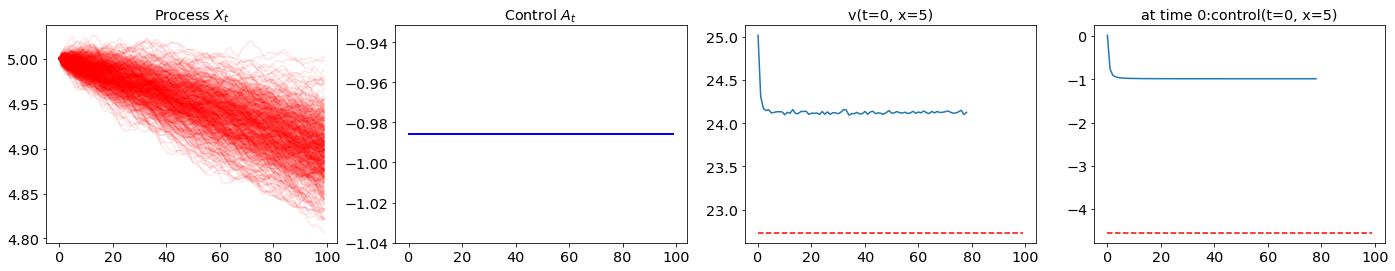

 79%|██████████████████████████████        | 7900/10000 [16:12<03:53,  9.00it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.1 
 theoretical optimal control at time 0: -4.55


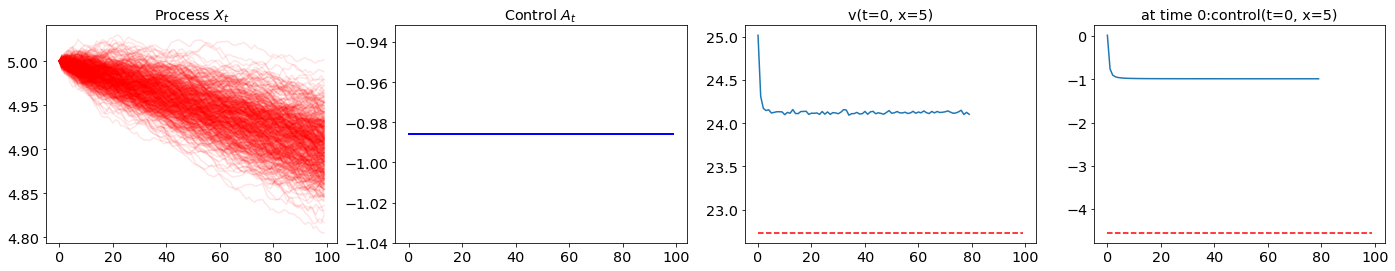

 80%|██████████████████████████████▍       | 8000/10000 [16:24<03:43,  8.95it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.13 
 theoretical optimal control at time 0: -4.55


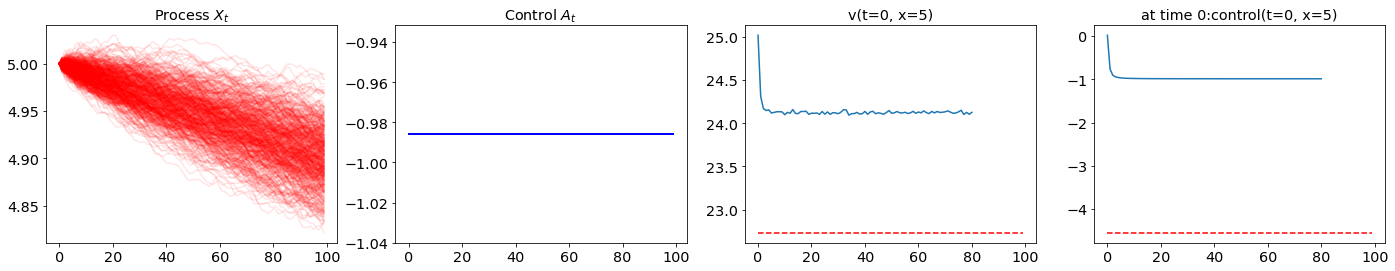

 81%|██████████████████████████████▊       | 8100/10000 [16:36<03:29,  9.07it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.14 
 theoretical optimal control at time 0: -4.55


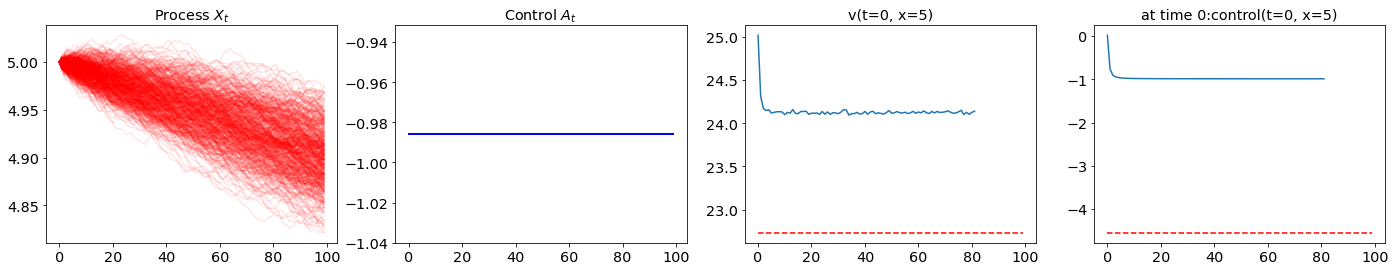

 82%|███████████████████████████████▏      | 8200/10000 [16:48<03:20,  9.00it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.12 
 theoretical optimal control at time 0: -4.55


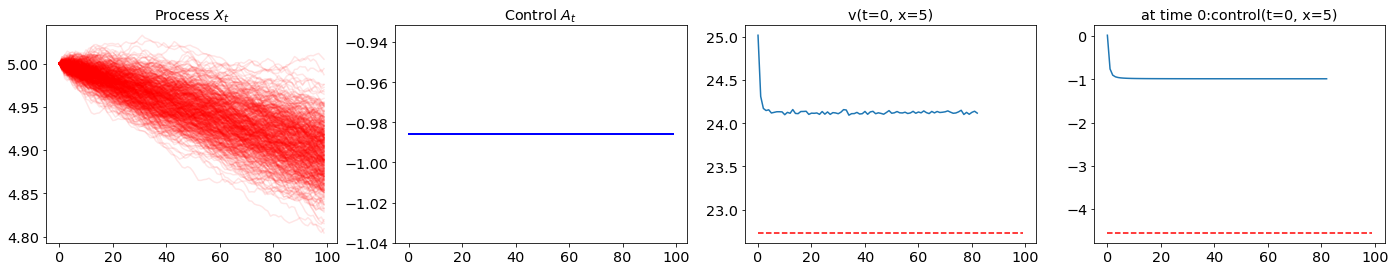

 83%|███████████████████████████████▌      | 8300/10000 [17:01<03:09,  8.96it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.15 
 theoretical optimal control at time 0: -4.55


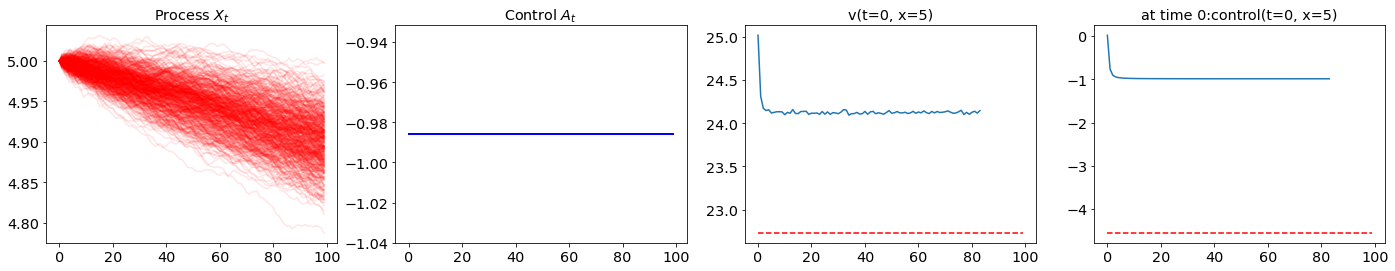

 84%|███████████████████████████████▉      | 8400/10000 [17:13<02:58,  8.97it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.12 
 theoretical optimal control at time 0: -4.55


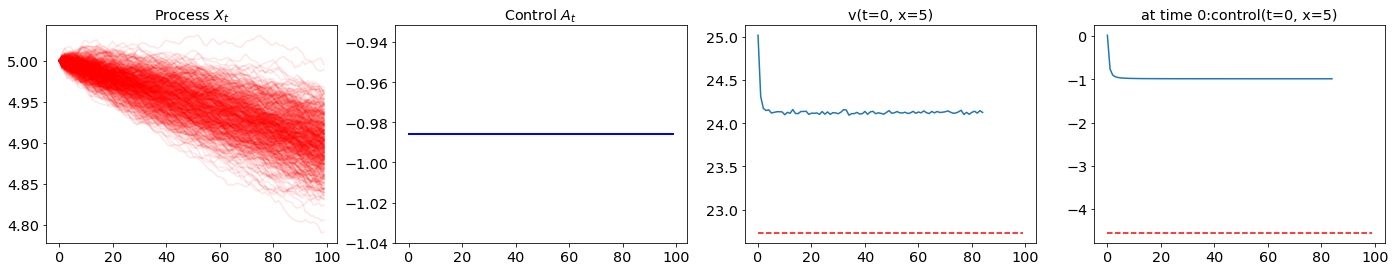

 85%|████████████████████████████████▎     | 8500/10000 [17:25<02:44,  9.12it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.11 
 theoretical optimal control at time 0: -4.55


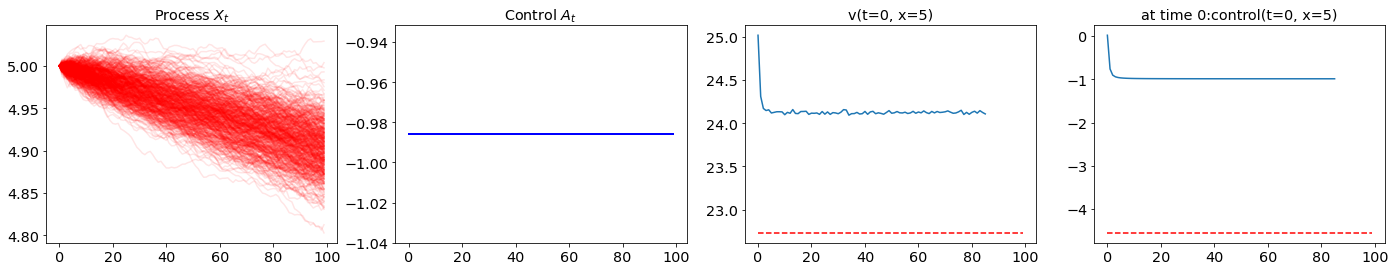

 86%|████████████████████████████████▋     | 8600/10000 [17:37<02:38,  8.84it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.12 
 theoretical optimal control at time 0: -4.55


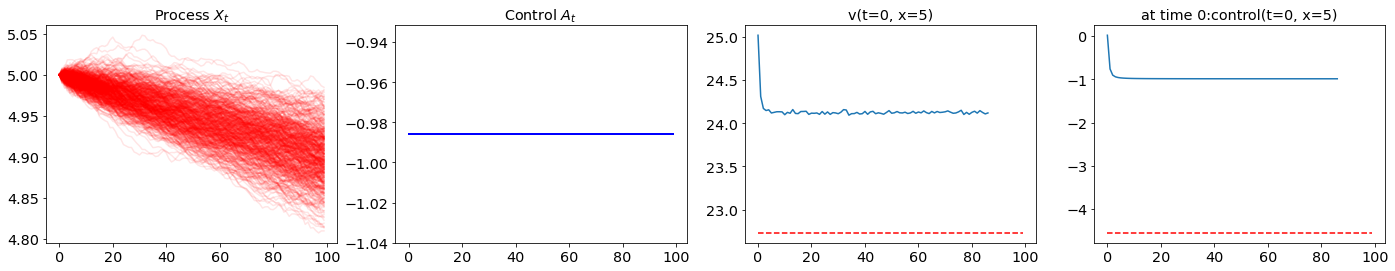

 87%|█████████████████████████████████     | 8700/10000 [17:50<02:24,  9.01it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.11 
 theoretical optimal control at time 0: -4.55


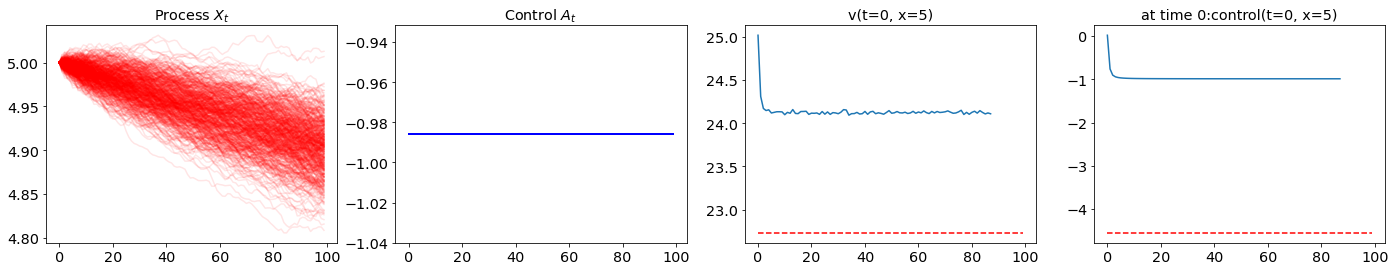

 88%|█████████████████████████████████▍    | 8800/10000 [18:02<02:12,  9.04it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.11 
 theoretical optimal control at time 0: -4.55


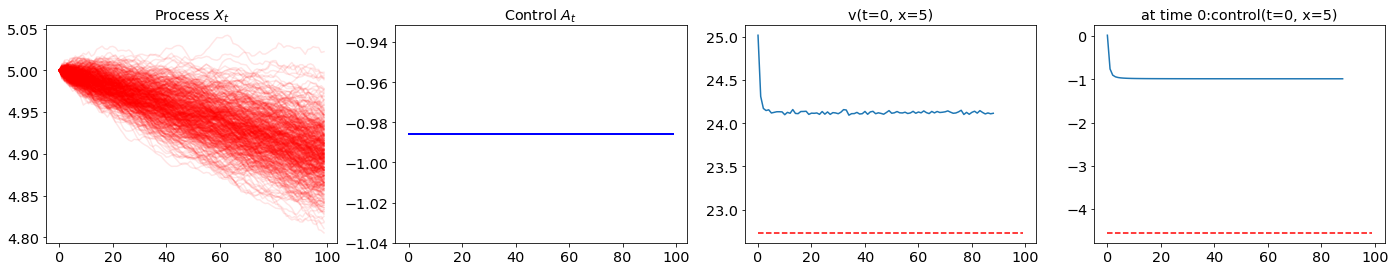

 89%|█████████████████████████████████▊    | 8900/10000 [18:14<02:03,  8.92it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.12 
 theoretical optimal control at time 0: -4.55


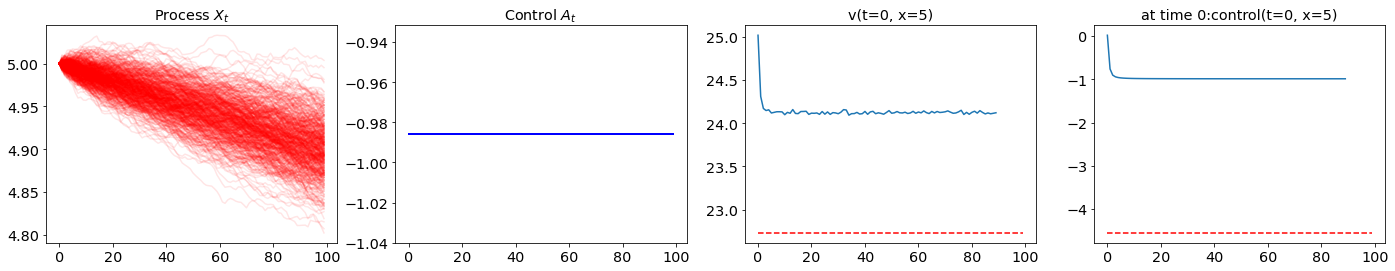

 90%|██████████████████████████████████▏   | 9000/10000 [18:26<01:51,  8.94it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.13 
 theoretical optimal control at time 0: -4.55


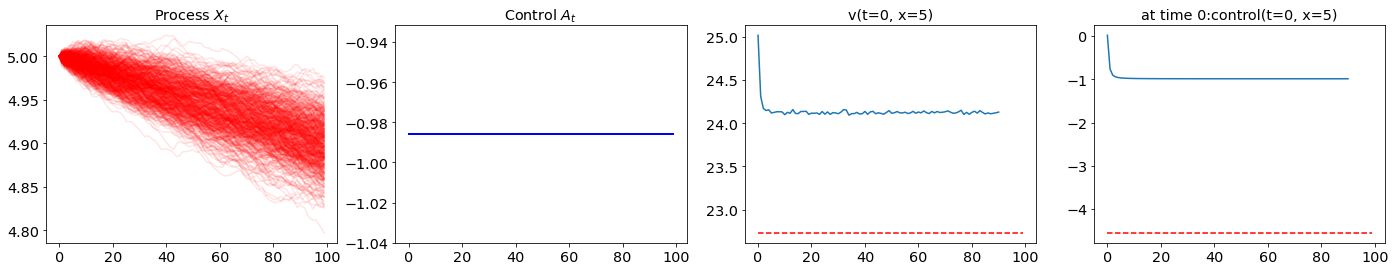

 91%|██████████████████████████████████▌   | 9100/10000 [18:38<01:39,  9.08it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.12 
 theoretical optimal control at time 0: -4.55


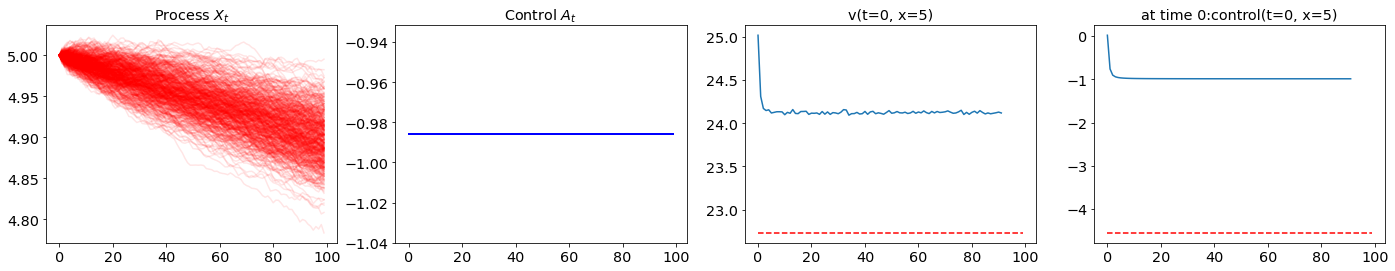

 92%|██████████████████████████████████▉   | 9200/10000 [18:50<01:28,  8.99it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.12 
 theoretical optimal control at time 0: -4.55


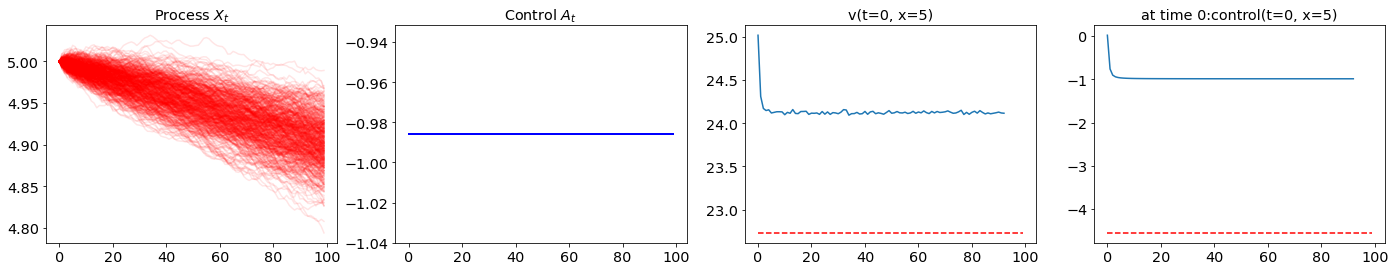

 93%|███████████████████████████████████▎  | 9300/10000 [19:03<01:18,  8.97it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.11 
 theoretical optimal control at time 0: -4.55


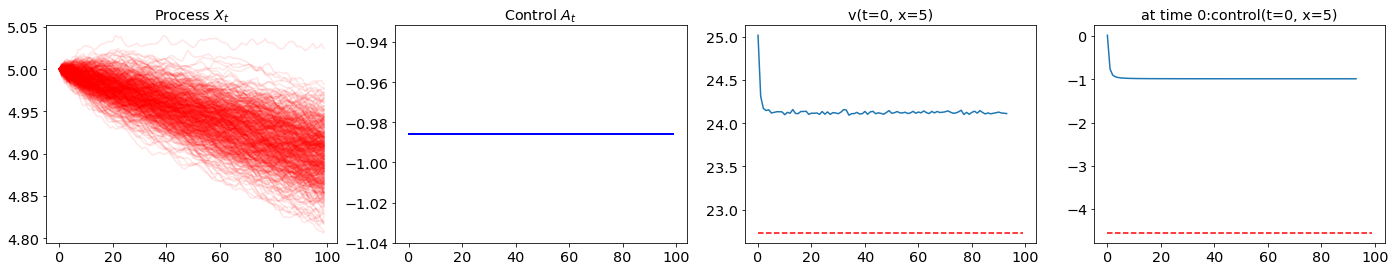

 94%|███████████████████████████████████▋  | 9400/10000 [19:15<01:10,  8.55it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.11 
 theoretical optimal control at time 0: -4.55


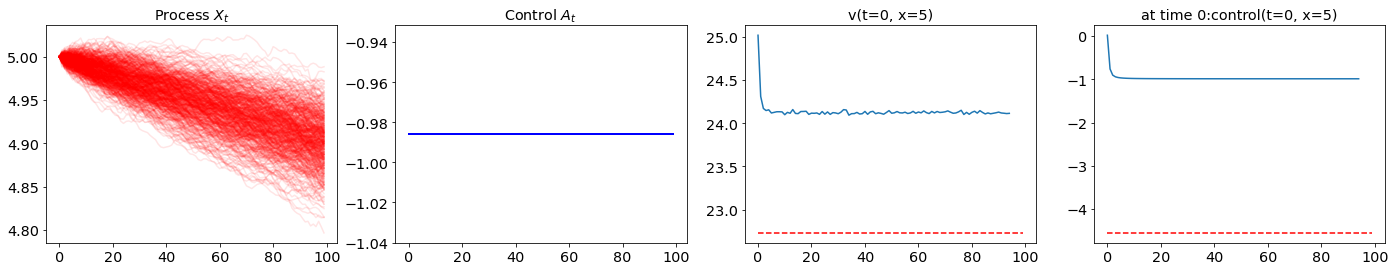

 95%|████████████████████████████████████  | 9500/10000 [19:27<00:55,  9.01it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.12 
 theoretical optimal control at time 0: -4.55


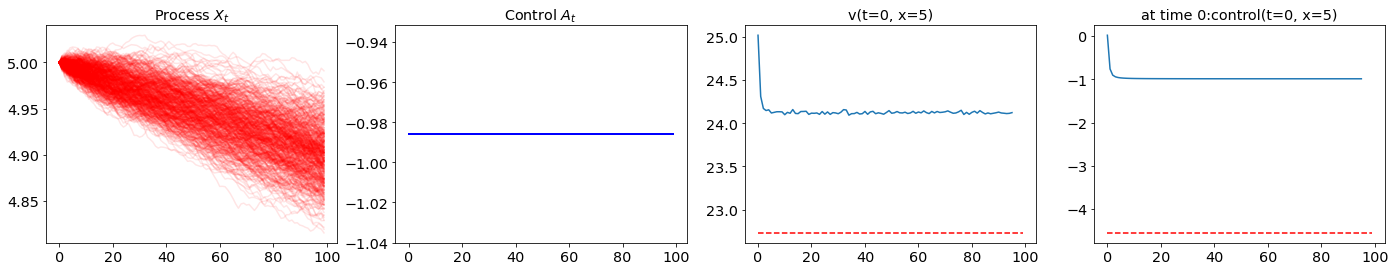

 96%|████████████████████████████████████▍ | 9600/10000 [19:39<00:44,  8.93it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.14 
 theoretical optimal control at time 0: -4.55


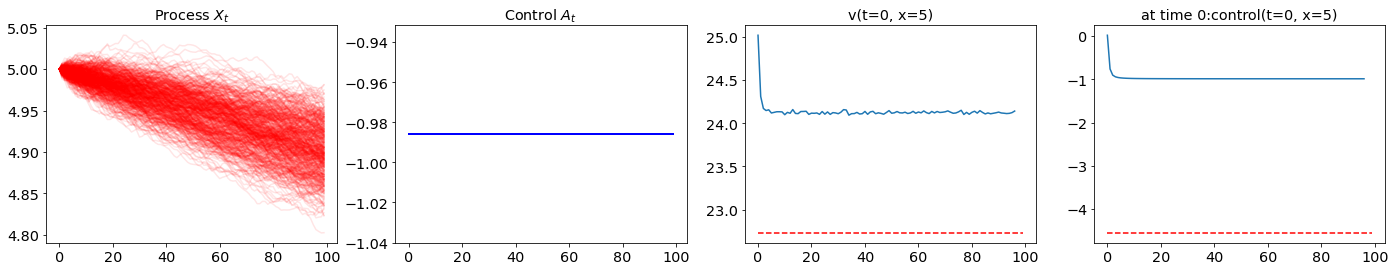

 97%|████████████████████████████████████▊ | 9700/10000 [19:52<00:33,  8.97it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.14 
 theoretical optimal control at time 0: -4.55


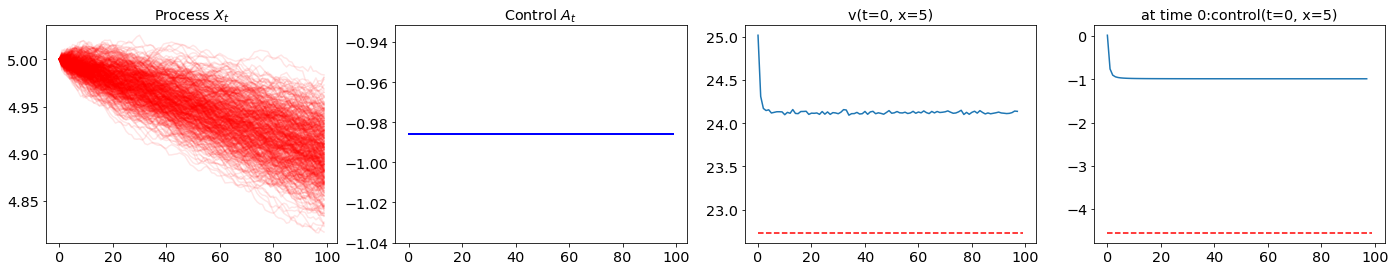

 98%|█████████████████████████████████████▏| 9800/10000 [20:04<00:22,  9.01it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.12 
 theoretical optimal control at time 0: -4.55


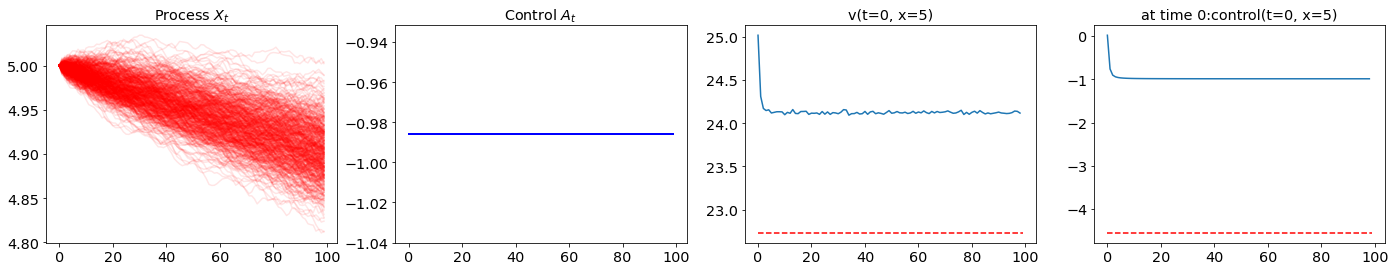

 99%|█████████████████████████████████████▌| 9900/10000 [20:16<00:11,  8.96it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.12 
 theoretical optimal control at time 0: -4.55


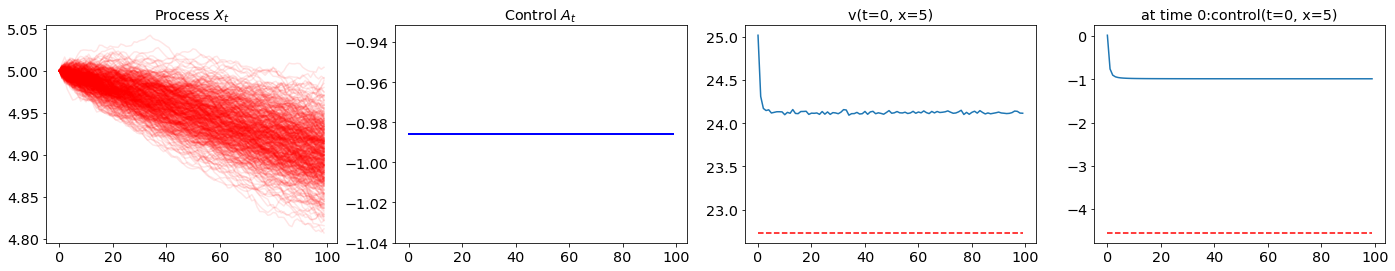

100%|█████████████████████████████████████▉| 9999/10000 [20:28<00:00,  9.01it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.12 
 theoretical optimal control at time 0: -4.55


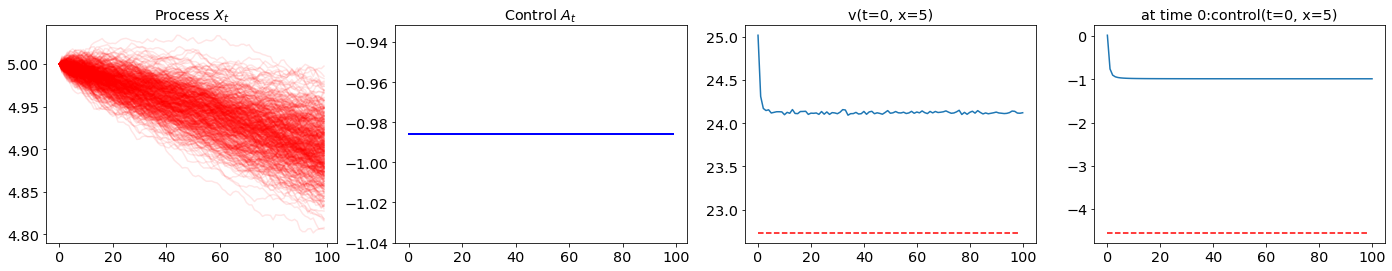

100%|█████████████████████████████████████| 10000/10000 [20:29<00:00,  8.13it/s]


In [12]:
# training loop
trange = tqdm.tqdm(range(iterations))

for step in trange:

    # random initial condition
#     x0 = np.random.uniform(low=1.0, high=2.0)
    x0 = 5
    x0_batch = x0*torch.ones(batch_size, 1, device=device)

    optimiser.zero_grad()

    generated_samples = model(x0_batch, ts)

    t = ts.expand(batch_size, t_size).unsqueeze(2)


    x = generated_samples[...,0]

    z = generated_samples[...,1:]

    tz = torch.cat([t, z], dim=2)


    alpha = model._func.h_theta(tz).clone().detach().requires_grad_(True)
    # print(alpha[1,:,0])
   
    the_integral = (T/t_size)*(Q_t*x[:,0]*x[:,0] + R_t*alpha[:,0,0]*alpha[:,0,0])
    for i in range(1,t_size):
      the_integral += (T/t_size)*(Q_t*x[:,i]*x[:,i] + R_t*alpha[:,i,0]*alpha[:,i,0])
    # could be in multi-dimensional 
  

    x_T = x[:,-1]
    part_xt = Q_T*x_T*x_T
#     print(x_T.shape)
#     print(the_integral.shape)
#     print(part_xt.shape)
    
    loss = torch.mean(part_xt + the_integral)

    loss.backward()

    optimiser.step()
    
    scheduler.step()

    if (step % iterations_per_print) == 0 or step == iterations - 1:
        with torch.no_grad():

            # random initial condition
            # x0 = np.random.uniform(low=1.0, high=2.0)

            # theoretical optimal control and value function v(t=0,x=x_0)
            v = x0**2*Q_T/(Q_T*T+1) + sigma**2*np.log(Q_T*T+1)
      
            # calculate the theoretical optimal control at time = 0
            # P_t_star = []
            # for i in range(T/dt):
            #   P_t_star.append(Q_T/(Q_T*(T-i*dt)+1))
            # P_t_star = np.array(P_t_star)  
            P_0_star = Q_T/(Q_T*T+1)          
            K_t_star = R_t*B_t*P_0_star
            a_0_star = -K_t_star * x0


            x0_batch = x0*torch.ones(batch_size, 1, device=device)

            generated_samples = model(x0_batch, ts)
            t = ts.expand(batch_size, t_size).unsqueeze(2)

            x = generated_samples[...,0]
            z = generated_samples[...,1:]
            tz = torch.cat([t, z], dim=2)
            
            alpha = model._func.h_theta(tz).cpu().numpy()
            x_T = x[:,-1]
            the_integral = 0

            for i in range(t_size):
              the_integral += (T/t_size)*(Q_t*x[:,i]*x[:,i] + R_t*alpha[:,i,0]*alpha[:,i,0])
            
            # could be in multi-dimensional 
            loss = torch.mean(Q_T*x_T*x_T + the_integral)
#             print(alpha)
#             print(loss)
            v_theo = np.round(v,2)
            a_theo = np.round(a_0_star,2)

            # print the two theoretical solution line
            v_list = []
            a_list = []
            for i in range(times):
                v_list.append(v_theo)
                a_list.append(a_theo)
            
            print(f' \n initial condition: {np.round(x0,2)} \n',
                  f'theoretical value function: {v_theo} \n', 
                  f'predicted value function: {np.round(loss.cpu().numpy().item(),2)} \n',
                  f'theoretical optimal control at time 0: {a_theo}'
                  )
            alpha_0 = torch.mean(torch.tensor(alpha[:,0]))
            losses.append(loss)
            controls.append(alpha_0)

            results_plot(model, x0_batch, losses, controls, T, batch_size, t_size_test, v_list, a_list, times)

In [13]:
torch.tensor([1,2,3,4])*torch.tensor([1,2,3,4])

tensor([ 1,  4,  9, 16])

In [14]:
x

tensor([[5.0000, 4.9966, 4.9984,  ..., 4.9141, 4.9088, 4.9109],
        [5.0000, 4.9999, 5.0042,  ..., 4.9562, 4.9538, 4.9536],
        [5.0000, 4.9997, 4.9983,  ..., 4.9124, 4.9053, 4.9055],
        ...,
        [5.0000, 4.9999, 5.0001,  ..., 4.8490, 4.8457, 4.8486],
        [5.0000, 5.0019, 4.9955,  ..., 4.8884, 4.8884, 4.8815],
        [5.0000, 5.0050, 5.0007,  ..., 4.8657, 4.8546, 4.8509]])